<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
This notebook Assign leading edge genes to clusters based on gene-pathway graph

<strong>Input Data:</strong>

`run_partitioning_bulkRNAseq.py` outputs


In [1]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')

from tqdm import tqdm
import numpy as np
import gseapy
from scipy.sparse import csr_matrix
from tqdm.contrib.concurrent import process_map
from functools import partial
from scipy.sparse.csgraph import shortest_path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx
import json

from ABCA7lof2.plotting_geneclusters import get_le_clusters, get_layout, plot_graph, plot_rep_names, get_top_genes
from ABCA7lof2.geneclusters import get_gene_pathway_matrix, compute_jaccard_all_clust
from ABCA7lof2.geneclusters import evaluate_cut, get_scores, get_kernighan_lin_clusters, get_gene_pathway_matrix, get_full_matrix_from_bipartite, plot_component, plot_edges, plot_nodes, group, compute_groupped_matrix, get_scores, find_similar_clusters, get_representative_name_per_cluster, get_kernighan_lin_clusters, get_gene_pathway_matrix, compute_groupped_matrix, get_full_matrix_from_bipartite


def get_representative_name_per_cluster(bipartite_mat, colnames_mat, rownames_mat, description_table, cluster, cluster_column, N=5):
    genes = set(description_table.loc[description_table['is_gene']&(description_table[cluster_column]==cluster)]['description'])
    paths = set(description_table.loc[np.invert(description_table['is_gene'])&(description_table[cluster_column]==cluster)]['description'])
    if len(paths)==0:
        return 'C.'+str(cluster), np.nan, np.nan, np.nan
    else:
        index_col = [x in genes for x in colnames_mat]
        index_row = [x in paths for x in rownames_mat]
        
        #ipdb.set_trace()
    
        sum_internal = np.sum(bipartite_mat[index_row][:,index_col], axis=1)
        sum_external = np.sum(bipartite_mat[index_row][:,np.invert(index_col)], axis=1)
        sum_ratio = sum_internal#/(sum_external+sum_internal)
        S = np.argsort(-1*sum_ratio)[:N]
        rep_name = rownames_mat[index_row][S]

        return rep_name #'C.'+str(cluster), rep_name.split(' (')[0], sum_internal[S], sum_internal[S]

# get rep names


def plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path, N, cur_labels):
    import re
    from adjustText import adjust_text
    colnames = np.array(mat_sub.columns)
    rownames = np.array(mat_sub.index)

    out = [get_representative_name_per_cluster(np.array(mat_sub), colnames, rownames, frame, x, N) for x in np.unique(frame['cluster'])]

    plt.figure(figsize = (1,1))
    a = plt.gca()
    a.axis('off')
    texts = []
    y = 0
    for i, cluster_name in enumerate(unique_clusters):
            index = cur_labels==cluster_name
            x, y = np.mean(pos[index], axis=0)

            props = dict(boxstyle='round', facecolor='white', alpha=1, edgecolor=colors[i])
            temp = [re.split(r' [(]GO|WP| R-',x)[0] for x in out[i]]
            T = ('\n').join(temp)
            plt.text(0, 0, T,  bbox=props, c ='black', fontsize = 10)#, #style = "italic")#colors[i]

            a = plt.gca()
            a.axis('off')
            plt.savefig(out_path + str(i) + '.pdf', bbox_inches="tight")
            plt.figure()
            #y+=0.01

def return_partitioning(pathways_path, celltype, kl_loss_path, data):
    mat = get_gene_pathway_matrix(pathways_path)
    kl_loss = np.load(kl_loss_path)
    seed = np.argmin(kl_loss)
    genes = set(data[celltype])
    frame, mat_sub = get_le_clusters(None, None, mat, seed, 50, S=genes)

    return frame, mat_sub

from scipy.optimize import linear_sum_assignment
from statsmodels.stats.multitest import multipletests
import matplotlib.patches as mpatches

def get_random_overlap(frame1, frame2, seed, size1, size2):
    x = set(frame1['description'].sample(n=size1, replace=False, random_state=seed))
    y = set(frame2['description'].sample(n=size2, replace=False, random_state=seed))
    return len(x.intersection(y))/len(x.union(y))

def get_true_overlap(frame1, frame2):
    x = set(frame1['description'])
    y = set(frame2['description'])
    return len(x.intersection(y))/len(x.union(y))

def adjust_pvalues(pvalues):
    pvalues_flat = pvalues.flatten()
    _, pvalues_corrected_flat, _, _ = multipletests(pvalues_flat, method='fdr_bh')
    pvalues_corrected = pvalues_corrected_flat.reshape(pvalues.shape)
    return pvalues_corrected

def sort_matrix(M):
    cost_matrix = -M
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    sorted_assignment = sorted(zip(col_ind, row_ind))  # sort by column index
    sorted_cols, sorted_rows = zip(*sorted_assignment)
    assigned_rows = list(sorted_rows)
    remaining_rows = [r for r in range(M.shape[0]) if r not in assigned_rows]
    new_row_order = assigned_rows + remaining_rows
    new_col_order = list(range(M.shape[1]))
    return new_row_order, new_col_order

def get_jaccard_matrix(frame1, frame2, iterations=10000):

    jaccard = np.zeros((len(np.unique(frame1['cluster'])), len(np.unique(frame2['cluster']))))
    pvalues = jaccard.copy()

    for i in tqdm(range(jaccard.shape[0])):
        frame1_temp = frame1[frame1['cluster']==i]
        for j in range(jaccard.shape[1]):
            frame2_temp = frame2[frame2['cluster']==j]

            true_overlap = get_true_overlap(frame1_temp, frame2_temp)
            random_overlaps = [get_random_overlap(frame1, frame2, seed, len(frame1_temp), len(frame2_temp)) for seed in range(iterations)]
            p_value = np.sum(np.array(random_overlaps) >= true_overlap)/iterations

            jaccard[i,j] = true_overlap
            pvalues[i,j] = p_value

    return jaccard, pvalues



def plot_jaccard_matrix(jaccard, adjusted_pvalues, new_row_order, new_col_order, title, xlabel, ylabel, label_y=-0.5):
    nrows, ncols = jaccard.shape
    jaccard_matrix = jaccard[new_row_order, :][:, new_col_order]
    pvalue_matrix = adjusted_pvalues[new_row_order, :][:, new_col_order]

    im = plt.imshow(jaccard_matrix, cmap='viridis', )
    plt.title(title, fontsize=10, pad=10)
    # Annotate each cell with its p-value
    for i in range(nrows):
        for j in range(ncols):
            # Format the p-value with 3 decimal places
            if pvalue_matrix[i, j] < 0.05:
                p_text = "*"
                plt.text(j, i, p_text, ha="center", va="center", color="w", fontsize=15)

    plt.xlabel(xlabel, labelpad=10)
    plt.ylabel(ylabel, labelpad=10)

    plt.legend().set_visible(False)
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('Jaccard Index')
    # Custom legend

    # Create a custom legend
    label = r'* = empirical $p_{adj} < 0.05$'
    #label = r'\textcolor{red}{*} = empirical $p_{adj} < 0.05$'

    #label = r'$\color{red}{*}$ = empirical $p_{adj} < 0.05$'

    legend_elements = [mpatches.Patch(color='white', label=label)]#, mpatches.Patch(color='red', label='up-regulated cluster'), mpatches.Patch(color='blue', label='down-regulated cluster')]
    plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.25, label_y), frameon=False)



import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_scores_per_cluster(data, frame, cluster_column):
    g_names  = np.array(frame['description'][frame['is_gene']])
    scores = pd.DataFrame(data['score'])
    scores.columns = ['iN']
    SCORES = np.array(scores.loc[g_names])

    names = np.unique(frame[cluster_column])
    temp = [SCORES[frame[cluster_column][frame['is_gene']]==i] for i in names]

    return dict(zip(names, temp))

def get_names_per_cluster(mat_sub, frame, cluster_column, N=5):
    out = [get_representative_name_per_cluster(np.array(mat_sub), np.array(mat_sub.columns), np.array(mat_sub.index), frame, x, cluster_column, N) for x in np.unique(frame[cluster_column])]
    return out

def plot_direction_colors(cluster_labels_1, cluster_labels_2, scores_1, scores_2, new_row_order, new_col_order, ax):

    g2_labels = np.array(cluster_labels_1)[new_row_order]
    y_labels = np.array(cluster_labels_2)[new_col_order]
    g2_means = ['down' if np.mean(scores_1[int(ix.split('.')[1])])<0 else 'up' for ix in g2_labels]
    y_means = ['down' if np.mean(scores_2[int(ix.split('.')[1])])<0 else 'up' for ix in y_labels]

    for tick_label, direction in zip(ax.get_xticklabels(), y_means):
        tick_label.set_color('red' if direction == 'up' else 'blue')

    # Color x tick labels similarly
    for tick_label, direction in zip(ax.get_yticklabels(), g2_means):
        tick_label.set_color('red' if direction == 'up' else 'blue')

# Add custom legend; blue square and a red square
import matplotlib.patches as mpatches

# for each row
# if there is a single True, assign the cluster to that column 
# if there is more than one True, assign the cluster to the one with the highest jaccard index
# if there is no True, don't assign 

def map_clusters_rows_to_cols(jaccard, adjusted_pvalues, row_prefix):

    binary_pvalues = adjusted_pvalues<0.05
    cluster_assignment = np.zeros(adjusted_pvalues.shape[0])

    for i in range(adjusted_pvalues.shape[0]):
        if np.sum(binary_pvalues[i,:])==1:
            cluster_assignment[i] = np.argmax(binary_pvalues[i,:])
        elif np.sum(binary_pvalues[i,:])>1:
            w = np.where(binary_pvalues[i,:])[0]
            cluster_assignment[i] = w[np.argmax(jaccard[i,w])]
        else:
            cluster_assignment[i] = np.nan

    clusters = [row_prefix+str(x) for x in np.arange(adjusted_pvalues.shape[0])]
    dictionary = dict(zip(clusters, cluster_assignment))
    dictionary = {k: v for k, v in dictionary.items() if not np.isnan(v)}
    dictionary_rows_to_cols_assignment = {v: k for k, v in dictionary.items()}
    return dictionary_rows_to_cols_assignment

def plot_densities(scores, colors_dict, names, clusters, title, figsize=(2.5, 5.5)):
    fig, axes = plt.subplots(len(clusters), 1, sharex=True, figsize=figsize)

    for index, cluster in enumerate(clusters):

        sns.distplot(scores[cluster], color=colors_dict[cluster], kde=True,
                    hist=None, label=str(cluster), ax=axes[index], kde_kws={'linewidth': 1})
        
        # Get the line data from the KDE so you can fill between it
        l1 = axes[index].lines[0]
        x1 = l1.get_xydata()[:, 0]
        y1 = l1.get_xydata()[:, 1]
        
        axes[index].spines[['right', 'top']].set_visible(False)
        axes[index].set_title(str(cluster), loc='left', y=.3, x=.05, fontweight='bold', fontsize=8)
        axes[index].axvline(np.mean(scores[cluster]), color=colors_dict[cluster])
        axes[index].axvline(0, color='grey', linestyle='dotted')
        axes[index].fill_between(x1, y1, color=colors_dict[cluster], alpha=0.3)
        axes[index].set_ylabel('')
        
        # Process the text content
        text_str = names[cluster]
        my_list = [re.split(r' [(]GO|WP| R-', x)[0] for x in text_str]
        x_list = []
        for s in my_list:
            words = s.split()
            if len(words) > 10:
                new_str = " ".join(words[:10])
            else:
                new_str = s.strip()
            x_list.append(new_str)
        T = ('\n').join(x_list)
        
        # Add text within a colored box (placed outside the plot area)
        axes[index].text(1.15, 0.9, T,
                    transform=axes[index].transAxes,  # axes coordinates
                    fontsize=8,
                    color='black',
                    ha='left', va='top',
                    bbox=dict(facecolor='none', alpha=1, edgecolor=colors_dict[cluster]))
        
        # Add an arrow pointing from the right edge (at x=1.0) to the text box at x=1.1
        axes[index].annotate("",
                        xy=(1.1, 0.8),      # text box location
                        xycoords=axes[index].transAxes,
                        xytext=(1.0, 0.8),    # starting point at the plot edge
                        textcoords=axes[index].transAxes,
                        arrowprops=dict(arrowstyle="->", color=colors_dict[cluster], lw=1))
        
    fig.text(-0.1, 0.5, 'Density', va='center', rotation='vertical', fontsize=8)
    axes[-1].set_xlabel('gene scores [-log(p-value)*sign(logFC)]', fontsize=8)

    # Add a main title and a secondary title for the text labels
    fig.text(0.1, .9, title, va='center', fontsize=8)
    fig.text(1, .9, 'Representative cluster terms', va='center', fontsize=8)

    plt.tight_layout(rect=[0.1, 0, 1, 0.95])

#plt.savefig('../../paper/extended_plots/e3_g2_density.pdf', bbox_inches='tight')
#plt.show()


In [3]:
# load the iN data
with open("../../processed_data/bulkRNAseq_fgsea_leading_edge2.json", 'r') as file:
    data = json.load(file)

path_to_paths = '../../processed_data/all_paths.npy'

# get the gene clusters
frame_pm = pd.read_csv('../../processed_data/pm_kl_frame.csv', index_col=0)
G2_frame, G2_mat = return_partitioning(path_to_paths, 'wt_g2', '../../processed_data/kl_loss_wt_g2.npy', data)
Y622_frame, Y622_mat = return_partitioning(path_to_paths, 'wt_y622', '../../processed_data/kl_loss_wt_y622.npy', data)
Choline_frame, Choline_mat = return_partitioning(path_to_paths, 'y622_choline', '../../processed_data/kl_loss_y622_choline.npy', data)

# make Y clusters continue from PM, and G2 clusters continue from Y
Y622_frame['new_cluster'] = Y622_frame['cluster'] + np.max(frame_pm['cluster'])
G2_frame['new_cluster'] = G2_frame['cluster'] + np.max(Y622_frame['new_cluster'])
Choline_frame['new_cluster'] = Choline_frame['cluster'] + np.max(G2_frame['new_cluster'])
frame_pm['new_cluster'] = frame_pm['cluster']

# load scores
# load DEGs
data1 = pd.read_csv('../../bulkRNAseq/y622_degs.csv', index_col=0)
data2 = pd.read_csv('../../bulkRNAseq/choline_degs.csv', index_col=0)
data3 = pd.read_csv('../../bulkRNAseq/g2_degs.csv', index_col=0)
data4 = pd.read_csv('../../bulkRNAseq/choline_batch2_degs.csv', index_col=0)

data1.head()
data2.head()
data1.index = data1['genes']
data2.index = data2['genes']
data3.index = data3['genes']
data4.index = data4['genes']
data1['score'] = -np.log10(data1['P.Value']) * np.sign(data1['logFC'])
data2['score'] = -np.log10(data2['P.Value']) * np.sign(data2['logFC'])
data3['score'] = -np.log10(data3['P.Value']) * np.sign(data3['logFC'])
data4['score'] = -np.log10(data4['P.Value']) * np.sign(data4['logFC'])

# get scores
scores_Y622 = get_scores_per_cluster(data1, Y622_frame, 'new_cluster')
scores_choline = get_scores_per_cluster(data2, Choline_frame, 'new_cluster')
scores_g2 = get_scores_per_cluster(data3, G2_frame, 'new_cluster')
scores = pd.read_csv('../../processed_data/all_scores_0825.csv', index_col=0)
scores['score'] = scores['Ex']
scores_pm = get_scores_per_cluster(scores, frame_pm, 'new_cluster')

pm_mat = pd.read_csv('../../processed_data/pm_kl_mat.csv', index_col=0)


(111, 356)


3it [00:03,  1.29s/it, tot_impr=700, last_impr=0, loss=473]  


(110, 334)


3it [00:00, 14.06it/s, tot_impr=671, last_impr=0, loss=354] 


(138, 313)


3it [00:00, 14.71it/s, tot_impr=960, last_impr=0, loss=827] 


100%|██████████| 10/10 [00:20<00:00,  2.09s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


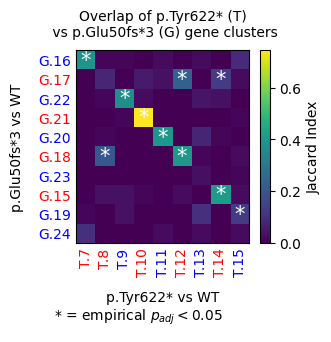

In [4]:
## p.Tyr622* vs p.Glu50fs*3 jaccard
jaccard_g2_y622, pvalues_g2_y622 = get_jaccard_matrix(G2_frame, Y622_frame, 1000)
adjusted_pvalues_g2_y622 = adjust_pvalues(pvalues_g2_y622)
new_row_order_g2_y622, new_col_order_g2_y622 = sort_matrix(jaccard_g2_y622)

iN_clusters = ['T.'+str(x) for x in np.unique(Y622_frame['new_cluster'])]
iN_G2_clusters = ['G.'+str(x) for x in np.unique(G2_frame['new_cluster'])]

plt.figure(figsize=(3.5, 2.5))

plot_jaccard_matrix(jaccard_g2_y622, adjusted_pvalues_g2_y622, new_row_order_g2_y622, new_col_order_g2_y622, 'Overlap of p.Tyr622* (T)\n vs p.Glu50fs*3 (G) gene clusters', 'p.Tyr622* vs WT', 'p.Glu50fs*3 vs WT', label_y=-0.5)

plt.yticks(ticks=np.arange(len(new_row_order_g2_y622)), labels=np.array(iN_G2_clusters)[new_row_order_g2_y622])
plt.xticks(ticks=np.arange(len(new_col_order_g2_y622)), labels=np.array(iN_clusters)[new_col_order_g2_y622], rotation=90)
plt.gca().tick_params(axis='both', which='both', length=0)

# Get the current axis to modify tick label colors
ax = plt.gca()
plot_direction_colors(iN_G2_clusters, iN_clusters, scores_g2, scores_Y622, new_row_order_g2_y622, new_col_order_g2_y622, ax)


plt.savefig('../../paper/extended_plots/jaccard_pT622_pG50fs3_vs_wt.png', bbox_inches='tight', dpi=300)

100%|██████████| 10/10 [00:20<00:00,  2.06s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


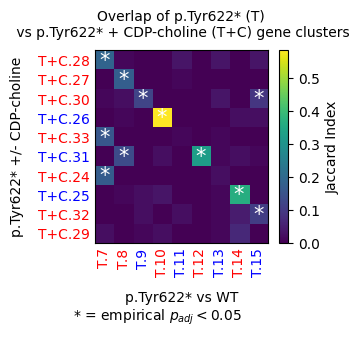

In [5]:
## p.Tyr622* vs p.Tyr622* + CDP-choline jaccard
jaccard_choline, pvalues_choline = get_jaccard_matrix(Choline_frame, Y622_frame, 1000)
adjusted_pvalues_choline = adjust_pvalues(pvalues_choline)
new_row_order_choline, new_col_order_choline = sort_matrix(jaccard_choline)

iN_clusters = ['T.'+str(x) for x in np.unique(Y622_frame['new_cluster'])]
iNC_clusters = ['T+C.'+str(x) for x in np.unique(Choline_frame['new_cluster'])]

plt.figure(figsize=(3.5, 2.5))
plot_jaccard_matrix(jaccard_choline, adjusted_pvalues_choline, new_row_order_choline, new_col_order_choline, 'Overlap of p.Tyr622* (T)\n vs p.Tyr622* + CDP-choline (T+C) gene clusters', 'p.Tyr622* vs WT', 'p.Tyr622* +/- CDP-choline')

plt.yticks(ticks=np.arange(len(new_row_order_choline)), labels=np.array(iNC_clusters)[new_row_order_choline])
plt.xticks(ticks=np.arange(len(new_col_order_choline)), labels=np.array(iN_clusters)[new_col_order_choline], rotation=90)
plt.gca().tick_params(axis='both', which='both', length=0)

ax = plt.gca()
plot_direction_colors(iNC_clusters, iN_clusters, scores_choline, scores_Y622, new_row_order_choline, new_col_order_choline, ax)


plt.savefig('../../paper/main_plots/jaccard_pT622_with_choline.png', bbox_inches='tight', dpi=300)

In [6]:
# x = Choline_frame.drop_duplicates(subset='new_cluster')
# x.sort_values(by='new_cluster')


In [7]:
# frame_pm

In [9]:
# # load the pm clusters
# frame_pm = pd.read_csv('../../processed_data/pm_kl_frame.csv', index_col=0)
# ## # p.Tyr622* vs PM jaccard
# jaccard_pm_yc, pvalues_pm_yc = get_jaccard_matrix(frame_pm, Choline_frame, 1000)
# adjusted_pvalues_pm_yc = adjust_pvalues(pvalues_pm_yc)
# new_row_order_pm_yc, new_col_order_pm_yc = sort_matrix(jaccard_pm_yc)

# iN_clusters = ['T+C.'+str(x) for x in np.unique(Choline_frame['new_cluster'])]
# pm_clusters = ['PM.'+str(x) for x in np.arange(adjusted_pvalues_pm_yc.shape[0])]

# plt.figure(figsize=(3.5, 2.5))
# plot_jaccard_matrix(jaccard_pm_yc, adjusted_pvalues_pm_yc, new_row_order_pm_yc, new_col_order_pm_yc, 'Overlap of ABCA7 LoF (PM) \n vs p.Tyr622* (T) gene clusters', 'p.Tyr622* vs WT', 'ABCA7 LoF vs Control (PM)')

# plt.yticks(ticks=np.arange(len(new_row_order_pm_yc)), labels=np.array(pm_clusters)[new_row_order_pm_yc])
# plt.xticks(ticks=np.arange(len(new_col_order_pm_yc)), labels=np.array(iN_clusters)[new_col_order_pm_yc], rotation=90)
# plt.gca().tick_params(axis='both', which='both', length=0)

# ax = plt.gca()
# plot_direction_colors(pm_clusters, iN_clusters, scores_pm, scores_choline, new_row_order_pm_yc, new_col_order_pm_yc, ax)

# #plt.savefig('../../paper/main_plots/jaccard_PM_pT622.png', bbox_inches='tight', dpi=300)

100%|██████████| 8/8 [00:16<00:00,  2.10s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


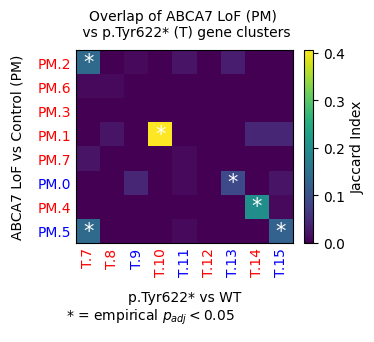

In [10]:
# load the pm clusters
frame_pm = pd.read_csv('../../processed_data/pm_kl_frame.csv', index_col=0)
## # p.Tyr622* vs PM jaccard
jaccard_pm_y, pvalues_pm_y = get_jaccard_matrix(frame_pm, Y622_frame, 1000)
adjusted_pvalues_pm_y = adjust_pvalues(pvalues_pm_y)
new_row_order_pm_y, new_col_order_pm_y = sort_matrix(jaccard_pm_y)

iN_clusters = ['T.'+str(x) for x in np.unique(Y622_frame['new_cluster'])]
pm_clusters = ['PM.'+str(x) for x in np.arange(adjusted_pvalues_pm_y.shape[0])]

plt.figure(figsize=(3.5, 2.5))
plot_jaccard_matrix(jaccard_pm_y, adjusted_pvalues_pm_y, new_row_order_pm_y, new_col_order_pm_y, 'Overlap of ABCA7 LoF (PM) \n vs p.Tyr622* (T) gene clusters', 'p.Tyr622* vs WT', 'ABCA7 LoF vs Control (PM)')

plt.yticks(ticks=np.arange(len(new_row_order_pm_y)), labels=np.array(pm_clusters)[new_row_order_pm_y])
plt.xticks(ticks=np.arange(len(new_col_order_pm_y)), labels=np.array(iN_clusters)[new_col_order_pm_y], rotation=90)
plt.gca().tick_params(axis='both', which='both', length=0)

ax = plt.gca()
plot_direction_colors(pm_clusters, iN_clusters, scores_pm, scores_Y622, new_row_order_pm_y, new_col_order_pm_y, ax)

plt.savefig('../../paper/main_plots/jaccard_PM_pT622.png', bbox_inches='tight', dpi=300)

In [11]:
# x = Y622_frame.drop_duplicates(subset='new_cluster')
# x.sort_values(by='new_cluster')


100%|██████████| 8/8 [00:19<00:00,  2.47s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


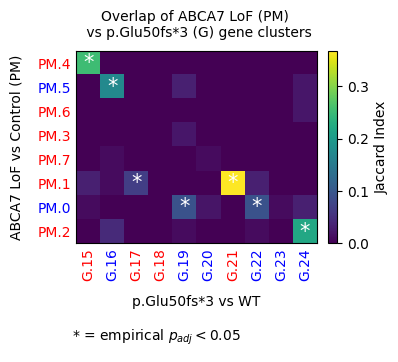

In [12]:
# load the pm clusters
frame_pm = pd.read_csv('../../processed_data/pm_kl_frame.csv', index_col=0)
## # p.Tyr622* vs PM jaccard
jaccard_pm_g2, pvalues_pm_g2 = get_jaccard_matrix(frame_pm, G2_frame, 1000)
adjusted_pvalues_pm_g2 = adjust_pvalues(pvalues_pm_g2)
new_row_order_pm_g2, new_col_order_pm_g2 = sort_matrix(jaccard_pm_g2)

iN_clusters = ['G.'+str(x) for x in np.unique(G2_frame['new_cluster'])]
pm_clusters = ['PM.'+str(x) for x in np.arange(adjusted_pvalues_pm_g2.shape[0])]

plt.figure(figsize=(3.5, 2.5))
plot_jaccard_matrix(jaccard_pm_g2, adjusted_pvalues_pm_g2, new_row_order_pm_g2, new_col_order_pm_g2, 'Overlap of ABCA7 LoF (PM) \n vs p.Glu50fs*3 (G) gene clusters', 'p.Glu50fs*3 vs WT', 'ABCA7 LoF vs Control (PM)', label_y=-0.6)

plt.yticks(ticks=np.arange(len(new_row_order_pm_g2)), labels=np.array(pm_clusters)[new_row_order_pm_g2])
plt.xticks(ticks=np.arange(len(new_col_order_pm_g2)), labels=np.array(iN_clusters)[new_col_order_pm_g2], rotation=90)
plt.gca().tick_params(axis='both', which='both', length=0)

ax = plt.gca()
plot_direction_colors(pm_clusters, iN_clusters, scores_pm, scores_g2, new_row_order_pm_g2, new_col_order_pm_g2, ax)

plt.savefig('../../paper/extended_plots/g2_pm_jaccard.png', bbox_inches='tight', dpi=300)

In [13]:
# sorted(unique_clusters_g2)

In [14]:
# {'PM.0': 'G.19',
#  'G.20': 'G.20',
#  'PM.5': 'G.16',
#  'PM.1': 'G.21',
#  'PM.2': 'G.24',
#  'PM.4': 'G.15',
#  'G.23': 'G.23',
#  'G.18': 'G.18'}

In [15]:
# x = G2_frame.drop_duplicates(subset='new_cluster')
# x.sort_values(by='new_cluster')


In [17]:
# Map PM to Y
best_matches = np.argmax(jaccard_pm_y, axis=0)
best_match_pvals = [adjusted_pvalues_pm_y[best_matches[i],i] for i in range(len(best_matches))]
best_matches_filtered = [best_matches[i] if best_match_pvals[i]<0.05 else np.nan for i in range(len(best_matches))]
pm_to_y = dict(zip(np.arange(jaccard_pm_y.shape[1]),best_matches_filtered))
Y622_frame['new_cluster_mapped'] = ['PM.'+str(pm_to_y[x]) for x in Y622_frame['cluster']]
Y622_frame['new_cluster_mapped'] = ['T.' + str(Y622_frame['new_cluster'][i]) if Y622_frame['new_cluster_mapped'][i]=='PM.nan' else Y622_frame['new_cluster_mapped'][i] for i in range(len(Y622_frame['new_cluster']))]

# # PM to YC 
# best_matches = np.argmax(jaccard, axis=0)
# best_match_pvals = [adjusted_pvalues_pm_y[best_matches[i],i] for i in range(len(best_matches))]
# best_matches_filtered = [best_matches[i] if best_match_pvals[i]<0.05 else np.nan for i in range(len(best_matches))]
# pm_to_y = dict(zip(np.arange(jaccard_pm_y.shape[1]),best_matches_filtered))
# Y622_frame['new_cluster_mapped'] = ['PM.'+str(pm_to_y[x]) for x in Y622_frame['cluster']]
# Y622_frame['new_cluster_mapped'] = ['T.' + str(Y622_frame['new_cluster'][i]) if Y622_frame['new_cluster_mapped'][i]=='PM.nan' else Y622_frame['new_cluster_mapped'][i] for i in range(len(Y622_frame['new_cluster']))]


# Map Y to YC
dictionary = dict(zip(Y622_frame['cluster'], Y622_frame['new_cluster_mapped']))
best_matches = np.argmax(jaccard_choline.T, axis=0)
best_match_pvals = [adjusted_pvalues_choline.T[best_matches[i],i] for i in range(len(best_matches))]
best_matches_filtered = [best_matches[i] if best_match_pvals[i]<0.05 else np.nan for i in range(len(best_matches))]
y_to_yc = dict(zip(np.arange(jaccard_choline.shape[0]),[dictionary.get(x, float('nan')) for x in best_matches_filtered]))
Choline_frame['new_cluster_mapped'] = [str(y_to_yc[x]) for x in Choline_frame['cluster']]
Choline_frame['new_cluster_mapped'] = ['T+C.' + str(Choline_frame['new_cluster'][i]) if Choline_frame['new_cluster_mapped'][i]=='nan' else Choline_frame['new_cluster_mapped'][i] for i in range(len(Choline_frame['new_cluster']))]

# Map PM to G
best_matches = np.argmax(jaccard_pm_g2, axis=0)
best_match_pvals = [adjusted_pvalues_pm_g2[best_matches[i],i] for i in range(len(best_matches))]
best_matches_filtered = [best_matches[i] if best_match_pvals[i]<0.05 else np.nan for i in range(len(best_matches))]
pm_to_g = dict(zip(np.arange(jaccard_pm_g2.shape[1]),best_matches_filtered))
G2_frame['new_cluster_mapped'] = ['PM.'+str(pm_to_g[x]) for x in G2_frame['cluster']]
G2_frame['new_cluster_mapped'] = ['G.' + str(G2_frame['new_cluster'][i]) if G2_frame['new_cluster_mapped'][i]=='PM.nan' else G2_frame['new_cluster_mapped'][i] for i in range(len(G2_frame['new_cluster']))]


# # Map Y to G
# best_matches = np.argmax(jaccard_g2_y622.T, axis=0)
# best_match_pvals = [adjusted_pvalues_g2_y622.T[best_matches[i],i] for i in range(len(best_matches))]
# best_matches_filtered = [best_matches[i] if best_match_pvals[i]<0.05 else np.nan for i in range(len(best_matches))]
# y_to_g = dict(zip(np.arange(jaccard_g2_y622.shape[0]),[dictionary.get(x, float('nan')) for x in best_matches_filtered]))
# G2_frame['new_cluster_mapped'] = [str(y_to_g[x]) for x in G2_frame['cluster']]
# G2_frame['new_cluster_mapped'] = ['G.' + str(G2_frame['new_cluster'][i]) if G2_frame['new_cluster_mapped'][i]=='nan' else G2_frame['new_cluster_mapped'][i] for i in range(len(G2_frame['new_cluster']))]


In [18]:
# x = Choline_frame.drop_duplicates(subset='new_cluster')
# x.sort_values(by='new_cluster')


In [19]:
# x = Y622_frame.drop_duplicates(subset='new_cluster')
# x.sort_values(by='new_cluster')


In [20]:
# x = G2_frame.drop_duplicates(subset='new_cluster')
# x.sort_values(by='new_cluster')


In [21]:

# plot_jaccard_matrix(jaccard_g2_y622, adjusted_pvalues_g2_y622, new_row_order_g2_y622, new_col_order_g2_y622, 'Overlap of p.Tyr622* (T)\n vs p.Glu50fs*3 (G) gene clusters', 'p.Tyr622* vs WT', 'p.Glu50fs*3 vs WT', label_y=-0.6)

# plt.yticks(ticks=np.arange(len(new_row_order_g2_y622)), labels=np.array(iN_G2_clusters)[new_row_order_g2_y622])
# plt.xticks(ticks=np.arange(len(new_col_order_g2_y622)), labels=np.array(iN_clusters)[new_col_order_g2_y622], rotation=90)
# plt.gca().tick_params(axis='both', which='both', length=0)


In [22]:
frame_pm['new_cluster_mapped'] = ['PM.'+str(x) for x in frame_pm['cluster']]

In [23]:
# # get labels
# g2_labels = np.array(iN_G2_clusters)[new_row_order_g2_y622]
# g2_means = ['down' if np.mean(scores_g2[x])<0 else 'up' for x in g2_labels]

# y_labels = np.array(iN_clusters)[new_col_order_g2_y622]
# y_means = ['down' if np.mean(scores_Y622[x])<0 else 'up' for x in y_labels]

# ## get dictionary with new cluster labels
# G2_frame_dict = dict(zip(G2_frame['cluster'], G2_frame['new_cluster_mapped']))
# y622_frame_dict = dict(zip(Y622_frame['cluster'], Y622_frame['new_cluster_mapped']))

# ## p.Tyr622* vs p.Glu50fs*3 jaccard with updated labels
# jaccard_g2_y622, pvalues_g2_y622 = get_jaccard_matrix(G2_frame, Y622_frame, 1000)
# adjusted_pvalues_g2_y622 = adjust_pvalues(pvalues_g2_y622)
# new_row_order_g2_y622, new_col_order_g2_y622 = sort_matrix(jaccard_g2_y622)

# iN_clusters = [y622_frame_dict[x] for x in np.unique(Y622_frame['cluster'])]    
# iN_G2_clusters = [G2_frame_dict[x] for x in np.unique(G2_frame['cluster'])]

# plt.figure(figsize=(3.5, 2.5))

# plot_jaccard_matrix(jaccard_g2_y622, adjusted_pvalues_g2_y622, new_row_order_g2_y622, new_col_order_g2_y622, 'Overlap of p.Tyr622* (T)\n vs p.Glu50fs*3 (G) gene clusters', 'p.Tyr622* vs WT', 'p.Glu50fs*3 vs WT', label_y=-0.6)

# plt.yticks(ticks=np.arange(len(new_row_order_g2_y622)), labels=np.array(iN_G2_clusters)[new_row_order_g2_y622])
# plt.xticks(ticks=np.arange(len(new_col_order_g2_y622)), labels=np.array(iN_clusters)[new_col_order_g2_y622], rotation=90)


# # Get the current axis to modify tick label colors
# ax = plt.gca()

# for tick_label, direction in zip(ax.get_xticklabels(), y_means):
#     tick_label.set_color('red' if direction == 'up' else 'blue')

# # Color x tick labels similarly
# for tick_label, direction in zip(ax.get_yticklabels(), g2_means):
#     tick_label.set_color('red' if direction == 'up' else 'blue')

# # Optionally remove tick marks
# ax.tick_params(axis='both', which='both', length=0)

# plt.gca().tick_params(axis='both', which='both', length=0)

# plt.savefig('../../paper/main_plots/iN_bulk_overlap_with_remapped_clusters.png', bbox_inches='tight', dpi=300)

In [24]:
# ## get dictionary with new cluster labels
# yc_frame_dict = dict(zip(Choline_frame['cluster'], Choline_frame['new_cluster_mapped']))
# y622_frame_dict = dict(zip(Y622_frame['cluster'], Y622_frame['new_cluster_mapped']))

# ## p.Tyr622* vs p.Tyr622* + CDP-choline jaccard
# jaccard_choline, pvalues_choline = get_jaccard_matrix(Choline_frame, Y622_frame, 1000)
# adjusted_pvalues_choline = adjust_pvalues(pvalues_choline)
# new_row_order_choline, new_col_order_choline = sort_matrix(jaccard_choline)

# iN_clusters = [y622_frame_dict[x] for x in np.unique(Y622_frame['cluster'])]
# iNC_clusters = [yc_frame_dict[x] for x in np.unique(Choline_frame['cluster'])]

# plt.figure(figsize=(3.5, 2.5))
# plot_jaccard_matrix(jaccard_choline, adjusted_pvalues_choline, new_row_order_choline, new_col_order_choline, 'Overlap of p.Tyr622* (T)\n vs p.Tyr622* + CDP-choline (T+C) gene clusters', 'p.Tyr622* vs WT', 'p.Tyr622* +/- CDP-choline')

# plt.yticks(ticks=np.arange(len(new_row_order_choline)), labels=np.array(iNC_clusters)[new_row_order_choline])
# plt.xticks(ticks=np.arange(len(new_col_order_choline)), labels=np.array(iN_clusters)[new_col_order_choline], rotation=90)
# plt.gca().tick_params(axis='both', which='both', length=0)

# # get labels
# yc_labels = np.array(iNC_clusters)[new_row_order_choline]
# yc_means = ['down' if np.mean(scores_choline[x])<0 else 'up' for x in yc_labels]

# y_labels = np.array(iN_clusters)[new_col_order_choline]
# y_means = ['down' if np.mean(scores_Y622[x])<0 else 'up' for x in y_labels]


# # Get the current axis to modify tick label colors
# ax = plt.gca()

# for tick_label, direction in zip(ax.get_xticklabels(), y_means):
#     tick_label.set_color('red' if direction == 'up' else 'blue')

# # Color x tick labels similarly
# for tick_label, direction in zip(ax.get_yticklabels(), yc_means):
#     tick_label.set_color('red' if direction == 'up' else 'blue')

# # Optionally remove tick marks
# ax.tick_params(axis='both', which='both', length=0)

# plt.gca().tick_params(axis='both', which='both', length=0)

# plt.savefig('../../paper/main_plots/choline_bulk_overlap_with_remapped_clusters.png', bbox_inches='tight', dpi=300)

In [25]:
# ## get dictionary with new cluster labels
# pm_dict = dict(zip(frame_pm['cluster'], frame_pm['new_cluster_mapped']))
# y622_frame_dict = dict(zip(Y622_frame['cluster'], Y622_frame['new_cluster_mapped']))

# ## # p.Tyr622* vs PM jaccard
# jaccard_pm_y, pvalues_pm_y = get_jaccard_matrix(frame_pm, Y622_frame, 1000)
# adjusted_pvalues_pm_y = adjust_pvalues(pvalues_pm_y)
# new_row_order_pm_y, new_col_order_pm_y = sort_matrix(jaccard_pm_y)

# iN_clusters = [y622_frame_dict[x] for x in np.unique(Y622_frame['cluster'])]
# pm_clusters = [pm_dict[x] for x in np.unique(frame_pm['cluster'])]

# plt.figure(figsize=(3.5, 2.5))
# plot_jaccard_matrix(jaccard_pm_y, adjusted_pvalues_pm_y, new_row_order_pm_y, new_col_order_pm_y, 'Overlap of ABCA7 LoF (PM) \n vs p.Tyr622* (T) gene clusters', 'p.Tyr622* vs WT', 'ABCA7 LoF vs Control (PM)')

# plt.yticks(ticks=np.arange(len(new_row_order_pm_y)), labels=np.array(pm_clusters)[new_row_order_pm_y])
# plt.xticks(ticks=np.arange(len(new_col_order_pm_y)), labels=np.array(iN_clusters)[new_col_order_pm_y], rotation=90)
# plt.gca().tick_params(axis='both', which='both', length=0)


# # get labels
# pm_labels = np.array(pm_clusters)[new_row_order_pm_y]
# pm_means = ['down' if np.mean(scores_pm[x])<0 else 'up' for x in pm_labels]

# y_labels = np.array(iN_clusters)[new_col_order_pm_y]
# y_means = ['down' if np.mean(scores_Y622[x])<0 else 'up' for x in y_labels]


# # Get the current axis to modify tick label colors
# ax = plt.gca()

# for tick_label, direction in zip(ax.get_xticklabels(), y_means):
#     tick_label.set_color('red' if direction == 'up' else 'blue')

# # Color x tick labels similarly
# for tick_label, direction in zip(ax.get_yticklabels(), pm_means):
#     tick_label.set_color('red' if direction == 'up' else 'blue')

# # Optionally remove tick marks
# ax.tick_params(axis='both', which='both', length=0)

# plt.gca().tick_params(axis='both', which='both', length=0)

# plt.savefig('../../paper/main_plots/pm_Y622_bulk_overlap_with_remapped_clusters.png', bbox_inches='tight', dpi=300)

In [26]:
# ## get dictionary with new cluster labels
# pm_dict = dict(zip(frame_pm['cluster'], frame_pm['new_cluster_mapped']))
# g2_frame_dict = dict(zip(G2_frame['cluster'], G2_frame['new_cluster_mapped']))

# ## # p.Tyr622* vs PM jaccard
# jaccard_pm_g2, pvalues_pm_g2 = get_jaccard_matrix(frame_pm, G2_frame, 1000)
# adjusted_pvalues_pm_g2 = adjust_pvalues(pvalues_pm_g2)
# new_row_order_pm_g2, new_col_order_pm_g2 = sort_matrix(jaccard_pm_g2)

# iN_clusters = [g2_frame_dict[x] for x in np.unique(G2_frame['cluster'])]
# pm_clusters = [pm_dict[x] for x in np.unique(frame_pm['cluster'])]

# plt.figure(figsize=(3.5, 2.5))
# plot_jaccard_matrix(jaccard_pm_g2, adjusted_pvalues_pm_g2, new_row_order_pm_g2, new_col_order_pm_g2, 'Overlap of ABCA7 LoF (PM) \n vs p.Glu50fs*3 (G) gene clusters', 'p.Glu50fs*3 vs WT', 'ABCA7 LoF vs Control (PM)', label_y=-0.6)

# plt.yticks(ticks=np.arange(len(new_row_order_pm_g2)), labels=np.array(pm_clusters)[new_row_order_pm_g2])
# plt.xticks(ticks=np.arange(len(new_col_order_pm_g2)), labels=np.array(iN_clusters)[new_col_order_pm_g2], rotation=90)
# plt.gca().tick_params(axis='both', which='both', length=0)


# # get labels
# pm_labels = np.array(pm_clusters)[new_row_order_pm_g2]
# pm_means = ['down' if np.mean(scores_pm[x])<0 else 'up' for x in pm_labels]

# g2_labels = np.array(iN_clusters)[new_col_order_pm_g2]
# g2_means = ['down' if np.mean(scores_g2[x])<0 else 'up' for x in g2_labels]


# # Get the current axis to modify tick label colors
# ax = plt.gca()

# for tick_label, direction in zip(ax.get_xticklabels(), g2_means):
#     tick_label.set_color('red' if direction == 'up' else 'blue')

# # Color x tick labels similarly
# for tick_label, direction in zip(ax.get_yticklabels(), pm_means):
#     tick_label.set_color('red' if direction == 'up' else 'blue')

# # Optionally remove tick marks
# ax.tick_params(axis='both', which='both', length=0)

# plt.gca().tick_params(axis='both', which='both', length=0)

# plt.savefig('../../paper/main_plots/pm_g2_bulk_overlap_with_remapped_clusters.png', bbox_inches='tight', dpi=300)

In [27]:
common_elements = (
    set(G2_frame['new_cluster_mapped']) |
    set(Y622_frame['new_cluster_mapped']) |
    set(frame_pm['new_cluster_mapped']) |
    set(Choline_frame['new_cluster_mapped'])
)

len(common_elements)

16

In [28]:
new_colors = [
    (0.847, 0.106, 0.376, 1.0),   # Row 0: Group 7, dark pink
    (0.902, 0.318, 0.000, 1.0),   # Row 1: Group 2, deep orange
    (1.000, 0.549, 0.000, 1.0),   # Row 2: Group 2, medium orange
    (1.000, 0.718, 0.302, 1.0),   # Row 3: Group 2, light orange
    (0.082, 0.396, 0.753, 1.0),   # Row 4: Group 0, dark blue
    (0.180, 0.490, 0.196, 1.0),   # Row 5: Group 5, dark green
    (0.941, 0.384, 0.573, 1.0),   # Row 6: Group 7, light pink
    (0.259, 0.647, 0.961, 1.0),   # Row 7: Group 0, light blue
    (0.400, 0.733, 0.416, 1.0),   # Row 8: Group 4, light green
    (0.890, 0.106, 0.137, 1.0),   # Row 9: Group 6, red
    (0.600, 0.196, 0.800, 1.0),   # Row 10: Group 8, dark purple
    (1.000, 0.843, 0.000, 1.0),   # Row 11: Group 9, gold/yellow
    (0.251, 0.878, 0.816, 1.0),   # Row 12: Group 10, turquoise
    (0.647, 0.165, 0.165, 1.0),   # Row 13: Group 11, brown
    (0.000, 0.500, 0.500, 1.0),   # Row 14: Group 12, deep teal
    (1.000, 0.000, 1.000, 1.0)
    ]
len(new_colors)

16

In [29]:
colors_dict = dict(zip(common_elements, new_colors))

colors_dict

{'PM.3': (0.847, 0.106, 0.376, 1.0),
 'PM.4': (0.902, 0.318, 0.0, 1.0),
 'PM.2': (1.0, 0.549, 0.0, 1.0),
 'T+C.29': (1.0, 0.718, 0.302, 1.0),
 'PM.1': (0.082, 0.396, 0.753, 1.0),
 'PM.5': (0.18, 0.49, 0.196, 1.0),
 'PM.0': (0.941, 0.384, 0.573, 1.0),
 'T.12': (0.259, 0.647, 0.961, 1.0),
 'T.11': (0.4, 0.733, 0.416, 1.0),
 'G.20': (0.89, 0.106, 0.137, 1.0),
 'T.8': (0.6, 0.196, 0.8, 1.0),
 'G.23': (1.0, 0.843, 0.0, 1.0),
 'PM.7': (0.251, 0.878, 0.816, 1.0),
 'G.18': (0.647, 0.165, 0.165, 1.0),
 'PM.6': (0.0, 0.5, 0.5, 1.0),
 'T.9': (1.0, 0.0, 1.0, 1.0)}

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


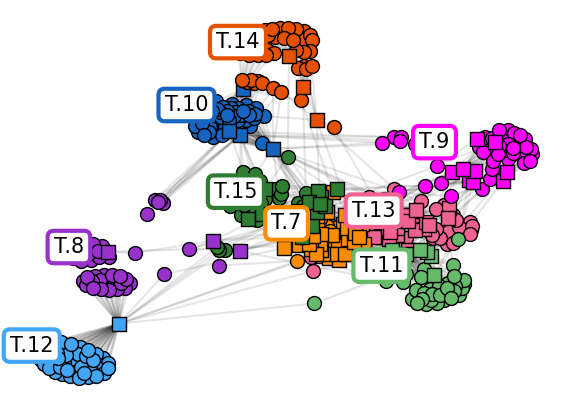

In [30]:
# get graph layout for y622
Y622_frame['cluster'] = ['T.' + str(x) for x in Y622_frame['new_cluster']]
s=10000
graph_y622, pos_y622, cur_labels_y622, unique_clusters_y622, colors_y622, layout_y622 = get_layout(Y622_frame, Y622_mat, s, 10)

D = dict(zip(Y622_frame['new_cluster_mapped'], Y622_frame['cluster']))
unique_clusters_y622 = [D[x] for x in np.unique(Y622_frame['new_cluster_mapped'])]

out_path = '../../paper/main_plots/y622_kl_clusters'
plot_graph(layout_y622, pos_y622, graph_y622, cur_labels_y622, unique_clusters_y622, [colors_dict[x] for x in np.unique(Y622_frame['new_cluster_mapped'])], out_path)

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


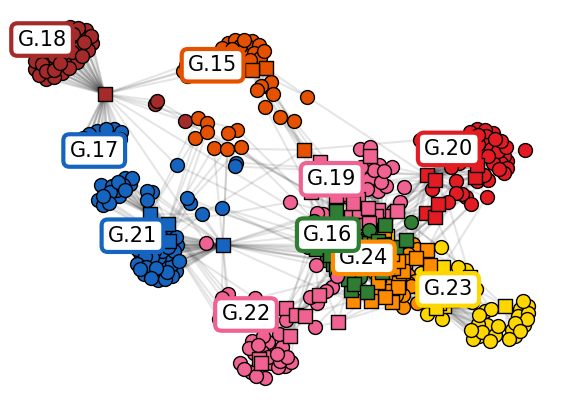

In [31]:
# get graph layout for y622
G2_frame['cluster'] = ['G.' + str(x) for x in G2_frame['new_cluster']]
s=10000
graph_g2, pos_g2, cur_labels_g2, unique_clusters_g2, colors_g2, layout_g2 = get_layout(G2_frame, G2_mat, s, 10)

D = dict(zip(G2_frame['new_cluster_mapped'], G2_frame['cluster']))
unique_clusters_g2 = [D[x] for x in np.unique(G2_frame['new_cluster_mapped'])]
unique_clusters_g2.append('G.17')
unique_clusters_g2.append('G.22')

out_path = '../../paper/main_plots/g2_kl_clusters'
C = [colors_dict[x] for x in np.unique(G2_frame['new_cluster_mapped'])]
C.append(colors_dict['PM.1'])
C.append(colors_dict['PM.0'])
plot_graph(layout_g2, pos_g2, graph_g2, cur_labels_g2, unique_clusters_g2, C, out_path)

In [32]:
# np.unique(G2_frame['new_cluster_mapped'])

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


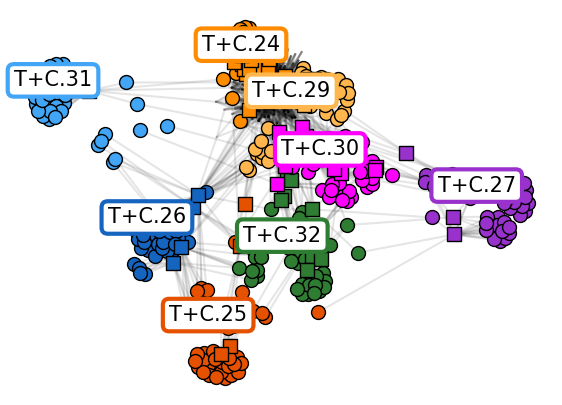

In [33]:
# get graph layout for choline treatment
Choline_frame['cluster'] = ['T+C.' + str(x) for x in Choline_frame['new_cluster']]
s=10000
graph_choline, pos_choline, cur_labels_choline, unique_clusters_choline, colors_choline, layout_choline = get_layout(Choline_frame, Choline_mat, s, 10)

D = dict(zip(Choline_frame['new_cluster_mapped'], Choline_frame['cluster']))
unique_clusters_choline = [D[x] for x in np.unique(Choline_frame['new_cluster_mapped'])]


out_path = '../../paper/main_plots/Y622_choline_kl_network'
plot_graph(layout_choline, pos_choline, graph_choline, cur_labels_choline, unique_clusters_choline, [colors_dict[x] for x in np.unique(Choline_frame['new_cluster_mapped'])], out_path)

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


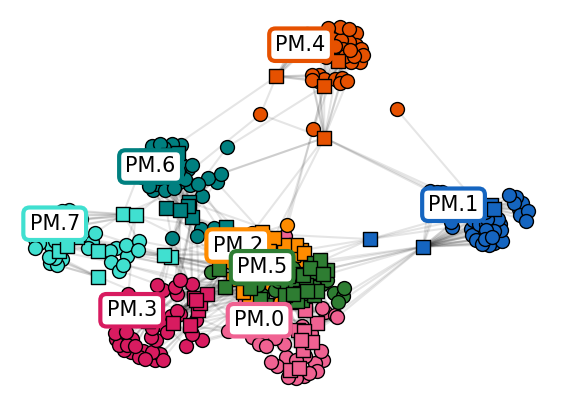

In [34]:
# get graph layout pm
frame_pm['cluster'] = frame_pm['new_cluster_mapped']

s=10000
graph_pm, pos_pm, cur_labels_pm, unique_clusters_pm, colors_pm, layout_pm = get_layout(frame_pm, pm_mat, s, 15)

out_path = '../../paper/main_plots/pm_kl_network'
plot_graph(layout_pm, pos_pm, graph_pm, cur_labels_pm, unique_clusters_pm, [colors_dict[x] for x in unique_clusters_pm], out_path)

In [35]:
# load DEGs
data1 = pd.read_csv('../../bulkRNAseq/y622_degs.csv', index_col=0)
data2 = pd.read_csv('../../bulkRNAseq/choline_degs.csv', index_col=0)
data3 = pd.read_csv('../../bulkRNAseq/g2_degs.csv', index_col=0)
data4 = pd.read_csv('../../bulkRNAseq/choline_batch2_degs.csv', index_col=0)

data1.head()
data2.head()
data1.index = data1['genes']
data2.index = data2['genes']
data3.index = data3['genes']
data4.index = data4['genes']
data1['score'] = -np.log10(data1['P.Value']) * np.sign(data1['logFC'])
data2['score'] = -np.log10(data2['P.Value']) * np.sign(data2['logFC'])
data3['score'] = -np.log10(data3['P.Value']) * np.sign(data3['logFC'])
data4['score'] = -np.log10(data4['P.Value']) * np.sign(data4['logFC'])

In [36]:

G2_frame['new_cluster2'] = ['G.' + str(x) for x in G2_frame['new_cluster']]
Y622_frame['new_cluster2'] = ['T.' + str(x) for x in Y622_frame['new_cluster']]
Choline_frame['new_cluster2'] = ['T+C.' + str(x) for x in Choline_frame['new_cluster']]

# get scores
scores_Y622 = get_scores_per_cluster(data1, Y622_frame, 'new_cluster2')
scores_choline = get_scores_per_cluster(data2, Choline_frame, 'new_cluster2')
scores_g2 = get_scores_per_cluster(data3, G2_frame, 'new_cluster2')
scores = pd.read_csv('../../processed_data/all_scores_0825.csv', index_col=0)
scores['score'] = scores['Ex']
scores_pm = get_scores_per_cluster(scores, frame_pm, 'new_cluster_mapped')

# get names
names_y622 = dict(zip(np.unique(Y622_frame['new_cluster2']), get_names_per_cluster(Y622_mat, Y622_frame, 'new_cluster2', 3)))
names_choline = dict(zip(np.unique(Choline_frame['new_cluster2']), get_names_per_cluster(Choline_mat, Choline_frame, 'new_cluster2', 3)))
names_g2 = dict(zip(np.unique(G2_frame['new_cluster2']), get_names_per_cluster(G2_mat, G2_frame, 'new_cluster2', 3)))
names_pm = dict(zip(np.unique(frame_pm['new_cluster_mapped']), get_names_per_cluster(pm_mat, frame_pm, 'new_cluster_mapped', 3)))


In [37]:
names_g2['G.17'] = ['no assigned pathways']


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_18856/1750027645.py:235: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores[cluster], color=colors_dict[cluster], kde=True,
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_18856/1750027645.py:235: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

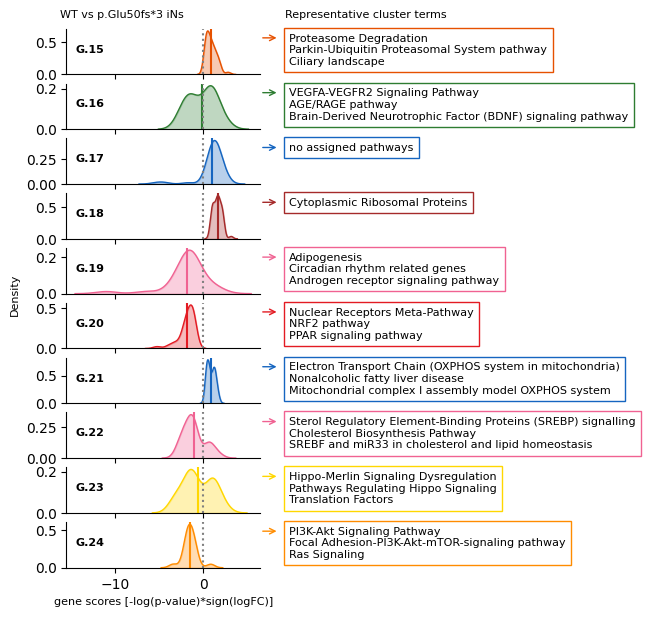

In [51]:
colors_dict_new = dict(zip(G2_frame['new_cluster2'], [colors_dict[x] for x in G2_frame['new_cluster_mapped']]))
plot_densities(scores_g2, colors_dict_new, names_g2, np.unique(G2_frame['new_cluster2']), 'WT vs p.Glu50fs*3 iNs', figsize=(2.5, 7))
plt.savefig('../../paper/main_plots/kl_densities_g.png', bbox_inches='tight', dpi=300)

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_18856/1750027645.py:235: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores[cluster], color=colors_dict[cluster], kde=True,
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_18856/1750027645.py:235: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

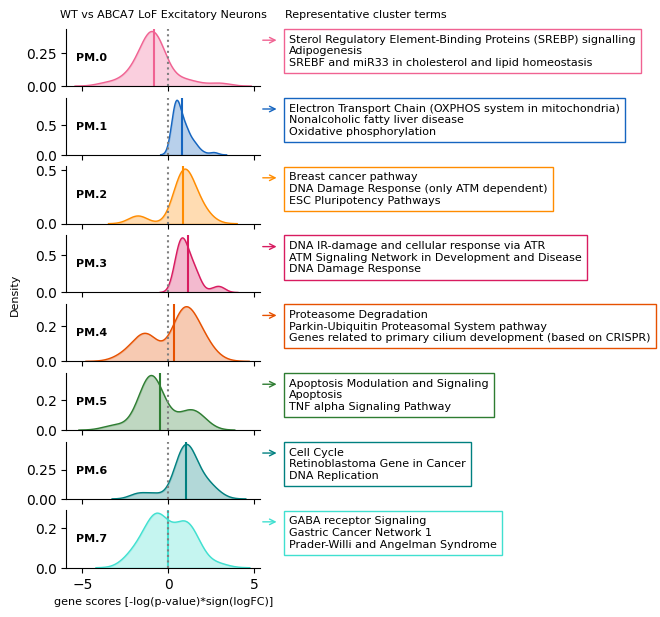

In [49]:

plot_densities(scores_pm, colors_dict, names_pm, np.unique(frame_pm['new_cluster_mapped']), 'WT vs ABCA7 LoF Excitatory Neurons', figsize=(2.5, 7))
plt.savefig('../../paper/main_plots/kl_densities.png', bbox_inches='tight', dpi=300)

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_18856/1750027645.py:235: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores[cluster], color=colors_dict[cluster], kde=True,
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_18856/1750027645.py:235: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

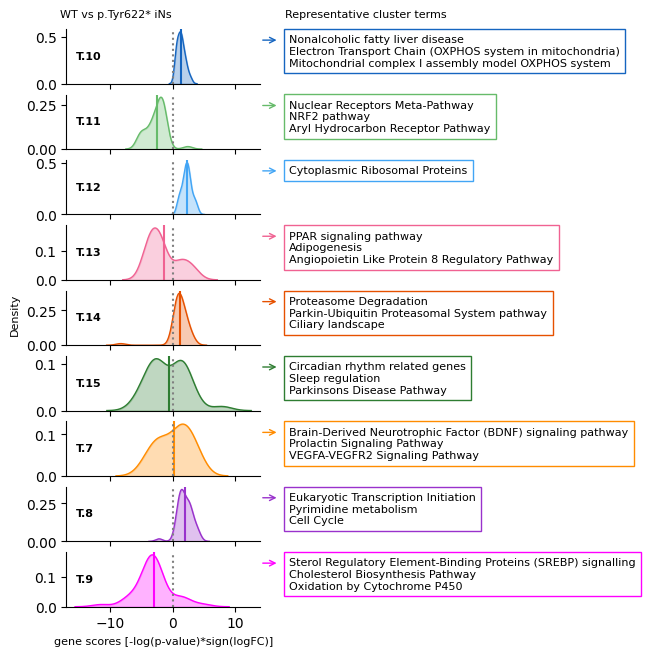

In [52]:
colors_dict_new = dict(zip(Y622_frame['new_cluster2'], [colors_dict[x] for x in Y622_frame['new_cluster_mapped']]))

plot_densities(scores_Y622, colors_dict_new, names_y622, np.unique(Y622_frame['new_cluster2']), 'WT vs p.Tyr622* iNs', figsize=(2.5, 7.5))
plt.savefig('../../paper/main_plots/kl_densities_Tyr622.png', bbox_inches='tight', dpi=300)

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_18856/1750027645.py:235: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scores[cluster], color=colors_dict[cluster], kde=True,
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_18856/1750027645.py:235: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

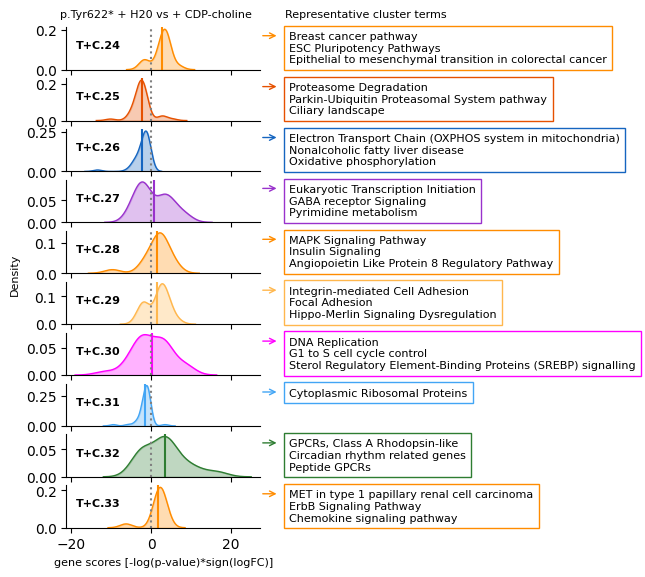

In [47]:
colors_dict_new = dict(zip(Choline_frame['new_cluster2'], [colors_dict[x] for x in Choline_frame['new_cluster_mapped']]))

plot_densities(scores_choline, colors_dict_new, names_choline, np.unique(Choline_frame['new_cluster2']), 'p.Tyr622* + H20 vs + CDP-choline', figsize=(2.5, 6.5))
plt.savefig('../../paper/main_plots/kl_densities_choline.png', bbox_inches='tight', dpi=300)

## Below is previous

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_84296/847569836.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp[c], color=colors[c], kde=True,
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_84296/847569836.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your cod

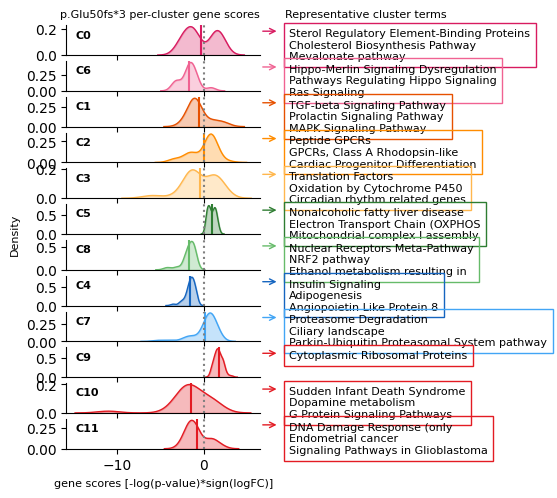

In [112]:

colors = new_colors  # new_colors defined earlier

fig, axes = plt.subplots(12, 1, sharex=True, figsize=(2.5, 5.5))

for i, c in enumerate([0, 6, 1, 2, 3, 5, 8, 4, 7, 9, 10, 11]):
    sns.distplot(temp[c], color=colors[c], kde=True,
                 hist=None, label=str(c), ax=axes[i], kde_kws={'linewidth': 1})
    
    # Get the line data from the KDE so you can fill between it
    l1 = axes[i].lines[0]
    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('C' + str(c), loc='left', y=.3, x=.05, fontweight='bold', fontsize=8)
    axes[i].axvline(np.mean(temp[c]), color=colors[c])
    axes[i].axvline(0, color='grey', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[c], alpha=0.3)
    axes[i].set_ylabel('')
    
    # Process the text content
    text_str = out[c]
    my_list = [re.split(r' [(]GO|WP| R-', x)[0] for x in text_str]
    x_list = []
    for s in my_list:
        words = s.split()
        if len(words) > 4:
            new_str = " ".join(words[:4])
        else:
            new_str = s.strip()
        x_list.append(new_str)
    T = ('\n').join(x_list)
    
    # Add text within a colored box (placed outside the plot area)
    axes[i].text(1.15, 0.9, T,
                 transform=axes[i].transAxes,  # axes coordinates
                 fontsize=8,
                 color='black',
                 ha='left', va='top',
                 bbox=dict(facecolor='none', alpha=1, edgecolor=colors[c]))
    
    # Add an arrow pointing from the right edge (at x=1.0) to the text box at x=1.1
    axes[i].annotate("",
                     xy=(1.1, 0.8),      # text box location
                     xycoords=axes[i].transAxes,
                     xytext=(1.0, 0.8),    # starting point at the plot edge
                     textcoords=axes[i].transAxes,
                     arrowprops=dict(arrowstyle="->", color=colors[c], lw=1))
    
fig.text(-0.1, 0.5, 'Density', va='center', rotation='vertical', fontsize=8)
axes[-1].set_xlabel('gene scores [-log(p-value)*sign(logFC)]', fontsize=8)

# Add a main title and a secondary title for the text labels
fig.text(0.1, .9, 'p.Glu50fs*3 per-cluster gene scores', va='center', fontsize=8)
fig.text(1, .9, 'Representative cluster terms', va='center', fontsize=8)

plt.tight_layout(rect=[0.1, 0, 1, 0.95])

#plt.savefig('../../paper/extended_plots/e3_g2_density.pdf', bbox_inches='tight')
#plt.show()


In [45]:
x = frame_g2[frame_g2['cluster']==0]
f = data3.loc[x[x['is_gene']]['description'].values]
f.sort_values('adj.P.Val', ascending=True)#[f['adj.P.Val']<0.05]

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B,score
genes,,,,,,,,
MSMO1,MSMO1,-0.494484,9.647776,-4.209778,0.001342,0.085818,-1.675448,-2.872140
DHCR7,DHCR7,-0.838090,8.252702,-4.063961,0.001729,0.096054,-1.889385,-2.762324
INSIG1,INSIG1,-0.838725,8.601333,-3.779744,0.002849,0.127212,-2.415718,-2.545311
SC5D,SC5D,-0.451714,8.064033,-3.745102,0.003030,0.128709,-2.450679,-2.518614
MVD,MVD,-0.595807,8.698922,-3.736136,0.003078,0.128827,-2.494813,-2.511696
IDI1,IDI1,-0.397151,9.525619,-3.672805,0.003446,0.138770,-2.637599,-2.462742
RPSA,RPSA,0.595778,7.122989,3.392287,0.005699,0.168615,-3.028418,2.244169
INSIG2,INSIG2,-0.417521,6.999416,-3.382552,0.005800,0.168914,-3.062361,-2.236540
RPS27,RPS27,0.716425,6.784337,3.263091,0.007199,0.180345,-3.242406,2.142727


### for E3 vs Y622

In [94]:
import statsmodels.stats.multitest as smm

data1['score'] = -np.log10(data1['P.Value']) * np.sign(data1['logFC'])
rnk = data1[['genes', 'score']].dropna()
rnk.columns = ['gene', 'score']
rnk = rnk.sort_values('score', ascending=False)

pre_res = gp.prerank(
    rnk=rnk,
    gene_sets=pathways,
    outdir="gseapy_out",
    permutation_num=1000,
    seed=6,
    min_size=5
)

temp = pre_res.res2d
p_values = temp['NOM p-val']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

# extract leading edge genes
temp = pre_res.res2d
temp = temp.sort_values('FDR')
genes = temp[temp['FDR']<0.05]
genes = set(np.concatenate([x.split(';') for x in genes['Lead_genes'].to_list()]))

In [86]:
temp[temp['FDR']<0.05].shape
print(len(genes))

335


In [95]:
# cluster genes
mat = get_gene_pathway_matrix('../../processed_data/all_paths.npy')
kl_loss = np.load('../../processed_data/kl_loss.npy')
seed = np.argmin(kl_loss)

frame_y622, mat_sub = get_le_clusters(None, 'Ex', mat, seed, 50, S=genes)

(124, 335)


4it [00:00, 15.38it/s, tot_impr=710, last_impr=0, loss=492] 


In [96]:
len(frame_y622['cluster'].value_counts())

10

In [56]:
x = frame_y622[frame_y622['cluster']==0]
f = data1.loc[x[x['is_gene']]['description'].values]
f.sort_values('adj.P.Val', ascending=True)[['logFC', 'P.Value', 'adj.P.Val']]#[f['adj.P.Val']<0.05]

,logFC,P.Value,adj.P.Val
genes,,,
ATP6AP2,0.500397,0.000014,0.000907
NDUFA1,0.549808,0.001044,0.016825
NDUFS4,0.413792,0.001775,0.023121
NDUFA4,0.536592,0.003587,0.035867
NDUFAF2,0.430684,0.005764,0.046552
NDUFC2,0.383357,0.007852,0.055362
NDUFA12,0.417669,0.011581,0.069300
TMEM126B,0.285170,0.012550,0.072104
NDUFB3,0.432966,0.014125,0.077284


(111, 268)


4it [00:00, 22.88it/s, tot_impr=685, last_impr=0, loss=285] 


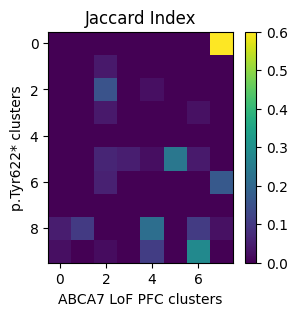

In [306]:
# get clusters for Ex
leading_edge = '../../processed_data/leading_edge_0825Ex.csv'

frame_pm, mat_sub_pm = get_le_clusters(leading_edge, 'Ex', mat, seed, 50)
dictionary = dict(zip(np.unique(frame_pm['cluster']), [2,7,4,1,3,6,5,0]))
frame_pm['cluster'] = [dictionary[x] for x in frame_pm['cluster']]

scores = pd.read_csv('../../processed_data/all_scores_0825.csv', index_col=0)

frame_gene = frame_y622[np.invert(frame_y622['is_gene'])]
frame_pm_gene = frame_pm[np.invert(frame_pm['is_gene'])]

out = np.zeros((len(np.unique(frame_gene['cluster'])), len(np.unique(frame_pm_gene['cluster']))))

for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        x = set(frame_gene[frame_gene['cluster']==i]['description'])
        y = set(frame_pm_gene[frame_pm_gene['cluster']==j]['description'])
        out[i,j] = len(x.intersection(y))/len(x.union(y))

import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
# Suppose 'out' is your similarity matrix.
# Create a cost matrix (negative because we want to maximize overlap)
cost = -out

# Solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cost)

# Reorder the matrix using the found permutation
sorted_out = out[np.ix_(row_ind, col_ind)]

# Display the sorted matrix
plt.imshow(out, cmap='viridis')#, vmax=1)
plt.colorbar()
plt.xlabel('ABCA7 LoF PFC clusters')
plt.ylabel('p.Tyr622* clusters')


#cbar = plt.colorbar()

plt.title('Jaccard Index')

plt.savefig('../../paper/extended_plots/pm_e3_y622_jaccard.png', bbox_inches='tight', dpi=300)
plt.show()


In [305]:
col_ind

array([7, 1, 2, 3, 0, 5, 4, 6])

In [134]:
# get graph layout
# plot graph
s=10000
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame_y622, mat_sub, s, 15)#10000


In [135]:
# get graph layout
# plot graph
s=10000
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame_y622, mat_sub, s, 15)#10000

new_colors = [
    (0.847, 0.106, 0.376, 1.0),   # Row 0: Group 7, dark pink
    (0.902, 0.318, 0.000, 1.0),   # Row 1: Group 2, deep orange
    (1.000, 0.549, 0.000, 1.0),   # Row 2: Group 2, medium orange
    (1.000, 0.718, 0.302, 1.0),   # Row 3: Group 2, light orange
    (0.082, 0.396, 0.753, 1.0),   # Row 4: Group 0, dark blue
    (0.180, 0.490, 0.196, 1.0),   # Row 5: Group 5, dark green
    (0.941, 0.384, 0.573, 1.0),   # Row 6: Group 7, light pink
    (0.259, 0.647, 0.961, 1.0),   # Row 7: Group 0, light blue
    (0.400, 0.733, 0.416, 1.0),   # Row 8: Group 4, light green
    (0.890, 0.106, 0.137, 1.0)    # Row 9: Group 6, red
]

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


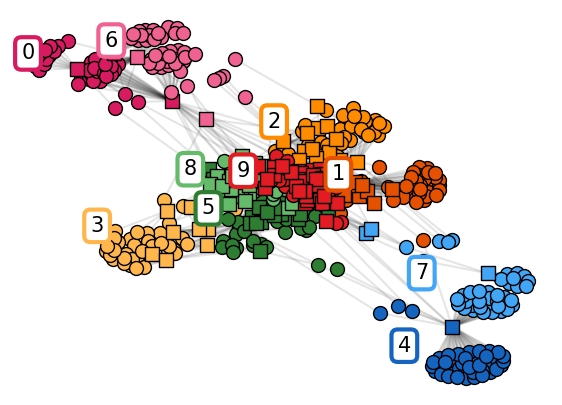

In [136]:
out_path = '../../paper/main_plots/E3_vs_Y622_kl'
plot_graph(layout, pos, graph, cur_labels, unique_clusters, new_colors, out_path)

In [137]:
N = 3
colnames = np.array(mat_sub.columns)
rownames = np.array(mat_sub.index)

out = [get_representative_name_per_cluster(np.array(mat_sub), colnames, rownames, frame_y622, x, N) for x in np.unique(frame_y622['cluster'])]

In [138]:
g_names  = np.array(frame_y622['description'][frame_y622['is_gene']])
scores = pd.DataFrame(data1['score'])
scores.columns = ['iN']
SCORES = np.array(scores.loc[g_names])

temp = [SCORES[frame_y622['cluster'][frame_y622['is_gene']]==i] for i in unique_clusters]

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_44261/970115365.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp[c], color=colors[c], kde=True,
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_44261/970115365.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your cod

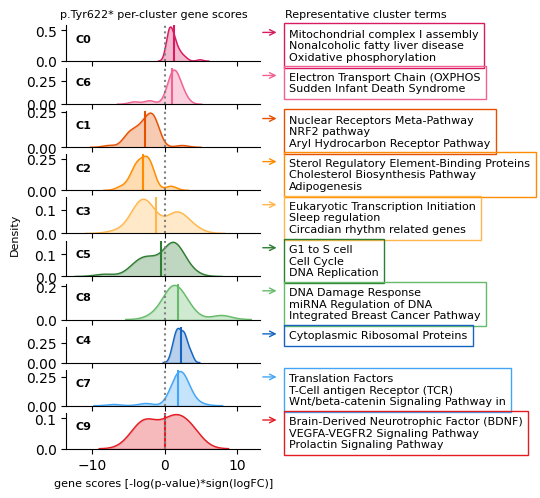

In [197]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

colors = new_colors  # new_colors defined earlier

fig, axes = plt.subplots(10, 1, sharex=True, figsize=(2.5, 5.5))

for i, c in enumerate([0, 6, 1, 2, 3, 5, 8, 4, 7, 9]):
    sns.distplot(temp[c], color=colors[c], kde=True,
                 hist=None, label=str(c), ax=axes[i], kde_kws={'linewidth': 1})
    
    # Get the line data from the KDE so you can fill between it
    l1 = axes[i].lines[0]
    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('C' + str(c), loc='left', y=.3, x=.05, fontweight='bold', fontsize=8)
    axes[i].axvline(np.mean(temp[c]), color=colors[c])
    axes[i].axvline(0, color='grey', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[c], alpha=0.3)
    axes[i].set_ylabel('')
    
    # Process the text content
    text_str = out[c]
    my_list = [re.split(r' [(]GO|WP| R-', x)[0] for x in text_str]
    x_list = []
    for s in my_list:
        words = s.split()
        if len(words) > 4:
            new_str = " ".join(words[:4])
        else:
            new_str = s.strip()
        x_list.append(new_str)
    T = ('\n').join(x_list)
    
    # Add text within a colored box (placed outside the plot area)
    axes[i].text(1.15, 0.9, T,
                 transform=axes[i].transAxes,  # axes coordinates
                 fontsize=8,
                 color='black',
                 ha='left', va='top',
                 bbox=dict(facecolor='none', alpha=1, edgecolor=colors[c]))
    
    # Add an arrow pointing from the right edge (at x=1.0) to the text box at x=1.1
    axes[i].annotate("",
                     xy=(1.1, 0.8),      # text box location
                     xycoords=axes[i].transAxes,
                     xytext=(1.0, 0.8),    # starting point at the plot edge
                     textcoords=axes[i].transAxes,
                     arrowprops=dict(arrowstyle="->", color=colors[c], lw=1))
    
fig.text(-0.1, 0.5, 'Density', va='center', rotation='vertical', fontsize=8)
axes[-1].set_xlabel('gene scores [-log(p-value)*sign(logFC)]', fontsize=8)

# Add a main title and a secondary title for the text labels
fig.text(0.1, .9, 'p.Tyr622* per-cluster gene scores', va='center', fontsize=8)
fig.text(1, .9, 'Representative cluster terms', va='center', fontsize=8)

plt.tight_layout(rect=[0.1, 0, 1, 0.95])

plt.savefig('../../paper/main_plots/e3_y622_density.pdf', bbox_inches='tight')
plt.show()


### Y622 + choline

In [57]:
import statsmodels.stats.multitest as smm

data2['score'] = -np.log10(data2['P.Value']) * np.sign(data2['logFC'])
rnk = data2[['genes', 'score']].dropna()
rnk.columns = ['gene', 'score']
rnk = rnk.sort_values('score', ascending=False)

pre_res = gp.prerank(
    rnk=rnk,
    gene_sets=pathways,
    outdir="gseapy_out",
    permutation_num=1000,
    seed=6,
    min_size=5
)

temp = pre_res.res2d
p_values = temp['NOM p-val']
# Apply FDR correction (Benjamini-Hochberg method)
_, fdr_corrected_pvals, _, _ = smm.multipletests(p_values, alpha=0.05, method='fdr_bh')
temp['FDR'] = fdr_corrected_pvals

# extract leading edge genes
temp = pre_res.res2d
temp = temp.sort_values('FDR')
genes = temp[temp['FDR']<0.05]
genes = set(np.concatenate([x.split(';') for x in genes['Lead_genes'].to_list()]))

In [58]:
# cluster genes
mat = get_gene_pathway_matrix('../../processed_data/all_paths.npy')
kl_loss = np.load('../../processed_data/kl_loss.npy')
seed = np.argmin(kl_loss)

frame_y622_choline, mat_sub = get_le_clusters(None, 'Ex', mat, seed, 50, S=genes)

(177, 397)


3it [00:00,  9.32it/s, tot_impr=1222, last_impr=0, loss=1358]   


In [61]:
x = frame_y622_choline[frame_y622_choline['cluster']==5]
f = data2.loc[x[x['is_gene']]['description'].values]
f.sort_values('adj.P.Val', ascending=True)[['logFC', 'P.Value', 'adj.P.Val']]#[f['adj.P.Val']<0.05]

,logFC,P.Value,adj.P.Val
genes,,,
CYP26A1,3.189111,5.177056e-09,3.766952e-07
RXRG,0.972997,6.273414e-09,4.371474e-07
CRABP1,1.217258,7.735835e-09,5.119646e-07
BDNF,0.667136,7.843221e-08,3.443174e-06
CRABP2,0.550545,4.299080e-06,8.158470e-05
SQLE,0.256960,6.583155e-05,6.958279e-04
HMGCR,0.372821,8.310706e-05,8.298105e-04
NF1,0.505429,1.545280e-04,1.327998e-03
DUSP10,0.420824,2.205772e-04,1.731588e-03


In [75]:
data2.loc['LPL']

genes             LPL
logFC        0.707034
AveExpr      1.831283
t            4.418303
P.Value      0.000337
adj.P.Val    0.002405
B           -0.314246
score        3.472318
Name: LPL, dtype: object

In [20]:
x = frame_y622_choline[frame_y622_choline['cluster']==5]
f = data2.loc[x[x['is_gene']]['description'].values]
f.sort_values('adj.P.Val', ascending=True).index#[f['adj.P.Val']<0.05]

Index(['CYP26A1', 'RXRG', 'CRABP1', 'BDNF', 'CRABP2', 'SQLE', 'HMGCR', 'NF1',
       'DUSP10', 'LSS', 'DHRS3', 'LPL', 'MTOR', 'GAD1', 'TSC2', 'RBP4', 'IDI1',
       'SCARB1', 'DHCR7', 'MVD', 'DDIT3', 'SC5D', 'RXRA', 'PRKAB1', 'CYP51A1',
       'DUSP1', 'TGFB2', 'RPS6', 'RPS6KB2', 'SUZ12'],
      dtype='object', name='genes')

In [238]:
# get graph layout
# plot graph
s=10000
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame_y622_choline, mat_sub, s, 15)#10000


In [243]:
len(frame_y622_choline['cluster'].value_counts())

12

In [245]:
new_colors = [
    (0.847, 0.106, 0.376, 1.0),   # Row 0: Group 7, dark pink
    (0.902, 0.318, 0.000, 1.0),   # Row 1: Group 2, deep orange
    (1.000, 0.549, 0.000, 1.0),   # Row 2: Group 2, medium orange
    (1.000, 0.718, 0.302, 1.0),   # Row 3: Group 2, light orange
    (0.082, 0.396, 0.753, 1.0),   # Row 4: Group 0, dark blue
    (0.180, 0.490, 0.196, 1.0),   # Row 5: Group 5, dark green
    (0.941, 0.384, 0.573, 1.0),   # Row 6: Group 7, light pink
    (0.259, 0.647, 0.961, 1.0),   # Row 7: Group 0, light blue
    (0.400, 0.733, 0.416, 1.0),   # Row 8: Group 4, light green
    (0.890, 0.106, 0.137, 1.0),
    (0.0, 0.588, 0.533, 1.0),
    (0.416, 0.105, 0.603, 1.0)
    # Row 9: Group 6, red
]

In [290]:
new_colors = [tuple(plt.get_cmap('viridis')(i/11)) for i in range(12)]


/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


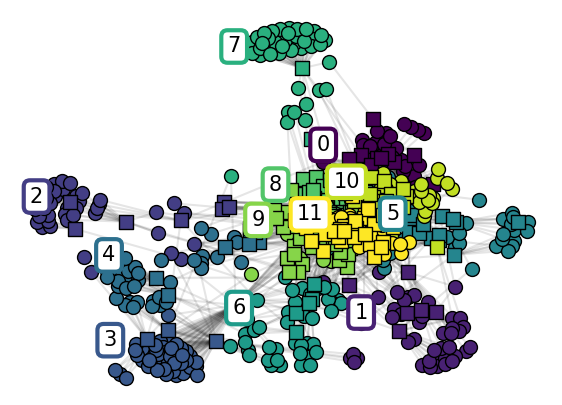

In [291]:
out_path = '../../paper/main_plots/Y622_choline_kl'
plot_graph(layout, pos, graph, cur_labels, unique_clusters, new_colors, out_path)

In [309]:
N = 3
colnames = np.array(mat_sub.columns)
rownames = np.array(mat_sub.index)

out = [get_representative_name_per_cluster(np.array(mat_sub), colnames, rownames, frame_y622_choline, x, N) for x in np.unique(frame_y622_choline['cluster'])]

In [321]:
g_names  = np.array(frame_y622_choline['description'][frame_y622_choline['is_gene']])
scores = pd.DataFrame(data2['score'])
scores.columns = ['iN']
SCORES = np.array(scores.loc[g_names])

temp = [SCORES[frame_y622_choline['cluster'][frame_y622_choline['is_gene']]==i] for i in unique_clusters]

In [311]:
len(frame_y622_choline['cluster'].value_counts())

12

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_44261/2335144520.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp[c], color=colors[i], kde=True,
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


TypeError: cannot use a string pattern on a bytes-like object

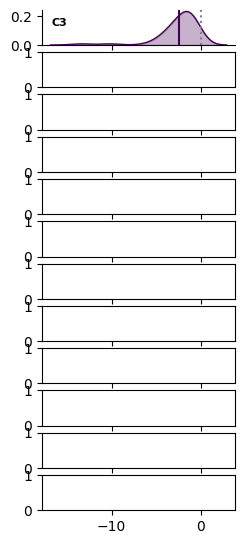

In [322]:
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

colors = [tuple(plt.get_cmap('viridis')(i/11)) for i in range(12)]
  # new_colors defined earlier

fig, axes = plt.subplots(12, 1, sharex=True, figsize=(2.5, 6.5))
#[3, 5, 6, 2]): #, 4, 0, 7, 9, 1, 8])
for i, c in enumerate(np.argsort([np.mean(x) for x in temp])):
    sns.distplot(temp[c], color=colors[i], kde=True,
                 hist=None, label=str(c), ax=axes[i], kde_kws={'linewidth': 1})
    
    # Get the line data from the KDE so you can fill between it
    l1 = axes[i].lines[0]
    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('C' + str(c), loc='left', y=.3, x=.05, fontweight='bold', fontsize=8)
    axes[i].axvline(np.mean(temp[c]), color=colors[i])
    axes[i].axvline(0, color='grey', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)
    axes[i].set_ylabel('')
    
    # Process the text content
    text_str = out[c]
    my_list = [re.split(r' [(]GO|WP| R-', x)[0] for x in text_str]
    x_list = []
    for s in my_list:
        words = s.split()
        if len(words) > 4:
            new_str = " ".join(words[:4])
        else:
            new_str = s.strip()
        x_list.append(new_str)
    T = ('\n').join(x_list)
    
    # Add text within a colored box (placed outside the plot area)
    axes[i].text(1.15, 0.9, T,
                 transform=axes[i].transAxes,  # axes coordinates
                 fontsize=8,
                 color='black',
                 ha='left', va='top',
                 bbox=dict(facecolor='none', alpha=1, edgecolor=colors[i]))
    
    # Add an arrow pointing from the right edge (at x=1.0) to the text box at x=1.1
    axes[i].annotate("",
                     xy=(1.1, 0.8),      # text box location
                     xycoords=axes[i].transAxes,
                     xytext=(1.0, 0.8),    # starting point at the plot edge
                     textcoords=axes[i].transAxes,
                     arrowprops=dict(arrowstyle="->", color=colors[i], lw=1))
    
fig.text(-0.1, 0.5, 'Density', va='center', rotation='vertical', fontsize=8)
axes[-1].set_xlabel('gene scores [-log(p-value)*sign(logFC)]', fontsize=8)

# Add a main title and a secondary title for the text labels
fig.text(0.1, .9, 'p.Tyr622* + CDP-choline gene scores', va='center', fontsize=8)
fig.text(1, .9, 'Representative cluster terms', va='center', fontsize=8)

plt.tight_layout(rect=[0.1, 0, 1, 0.95])

plt.savefig('../../paper/main_plots/y622_choline_density.pdf', bbox_inches='tight')
#plt.show()


In [288]:
dddd

[(0.267004, 0.004874, 0.329415, 1.0),
 (0.283072, 0.130895, 0.449241, 1.0),
 (0.262138, 0.242286, 0.520837, 1.0),
 (0.220057, 0.343307, 0.549413, 1.0),
 (0.177423, 0.437527, 0.557565, 1.0),
 (0.143343, 0.522773, 0.556295, 1.0),
 (0.119512, 0.607464, 0.540218, 1.0),
 (0.166383, 0.690856, 0.496502, 1.0),
 (0.319809, 0.770914, 0.411152, 1.0),
 (0.525776, 0.833491, 0.288127, 1.0),
 (0.762373, 0.876424, 0.137064, 1.0),
 (0.993248, 0.906157, 0.143936, 1.0)]

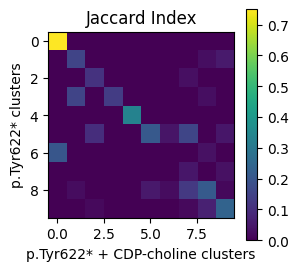

In [325]:

frame_gene = frame_y622[np.invert(frame_y622['is_gene'])]
frame_choline_gene = frame_y622_choline[np.invert(frame_y622_choline['is_gene'])]

out = np.zeros((len(np.unique(frame_gene['cluster'])), len(np.unique(frame_choline_gene['cluster']))))

for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        x = set(frame_gene[frame_gene['cluster']==i]['description'])
        y = set(frame_choline_gene[frame_choline_gene['cluster']==j]['description'])
        out[i,j] = len(x.intersection(y))/len(x.union(y))

import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
# Suppose 'out' is your similarity matrix.
# Create a cost matrix (negative because we want to maximize overlap)
cost = -out

# Solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cost)

# Reorder the matrix using the found permutation
sorted_out = out[np.ix_(row_ind, col_ind)]

# Display the sorted matrix
plt.imshow(sorted_out, cmap='viridis')#, vmax=1)
plt.colorbar()
plt.xlabel('p.Tyr622* + CDP-choline clusters')
plt.ylabel('p.Tyr622* clusters')


#cbar = plt.colorbar()

plt.title('Jaccard Index')

plt.savefig('../../paper/main_plots/choline_y622_jaccard.png', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
[0, 6, 1, 2, 3, 5, 8, 4, 7, 9]

In [273]:
np.argmax(out, axis=0)

array([5, 1, 5, 0, 3, 2, 5, 4, 9, 8, 9, 9])

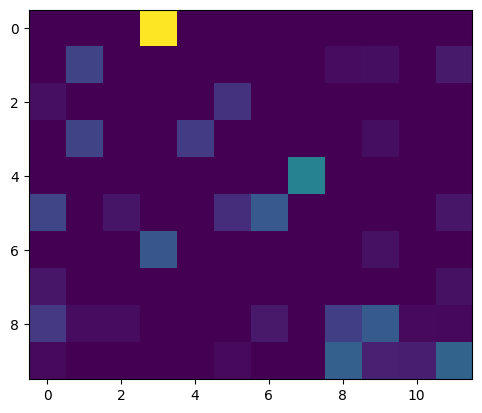

In [269]:
plt.imshow(out, cmap='viridis')#, vmax=1)


## Below is scrap

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

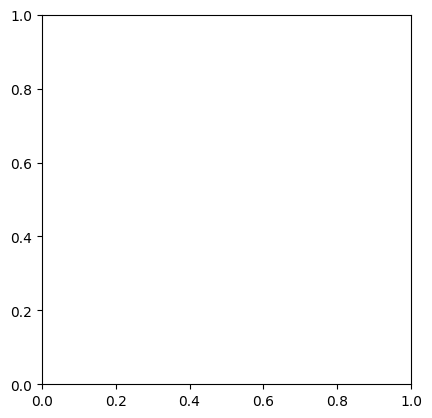

In [130]:
plt.imshow(out, cmap='viridis')#, vmax=1)

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_44261/2705700684.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp[i], color=colors[i], kde=True,
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_44261/2705700684.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your c

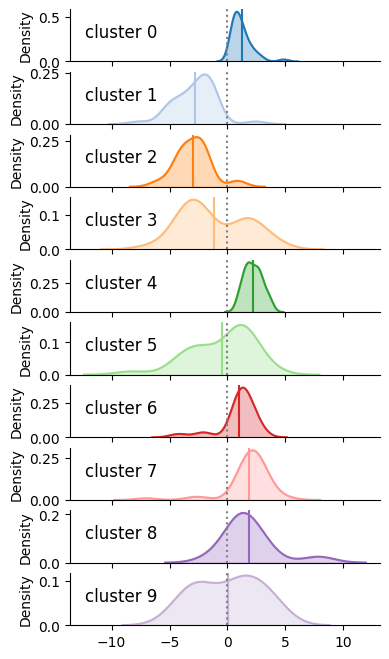

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

In [12]:
g_names  = np.array(frame_y622['description'][frame_y622['is_gene']])
scores = pd.DataFrame(data1['score'])
scores.columns = ['iN']
SCORES = np.array(scores.loc[g_names])


temp = [SCORES[frame_y622['cluster'][frame_y622['is_gene']]==i] for i in unique_clusters]
fig, axes = plt.subplots(10, 1, sharex=True, figsize=(4,8))

for i in range(len(temp)):
    plt.figure(figsize = (5,1))

    sns.distplot(temp[i], color=colors[i], kde=True,
        hist=None, label=str(i), ax=axes[i]);
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    axes[i].axvline(np.mean(temp[i]), color=colors[i])#, linestyle='dotted')
    axes[i].axvline(0, color='grey', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)

#fig.savefig(out_path+'_density.pdf')

#### Load data

#### Cluster genes by KL with seed for min loss

(124, 335)


4it [00:00, 14.81it/s, tot_impr=710, last_impr=0, loss=492] 


In [159]:
len(genes)

397

In [166]:
# dictionary = dict(zip(np.unique(frame['cluster']), [2,7,4,1,3,6,5,0]))
# frame['cluster'] = [dictionary[x] for x in frame['cluster']]

# plot graph
s=10000
graph, pos, cur_labels, unique_clusters, colors, layout = get_layout(frame, mat_sub, s, 15)#10000


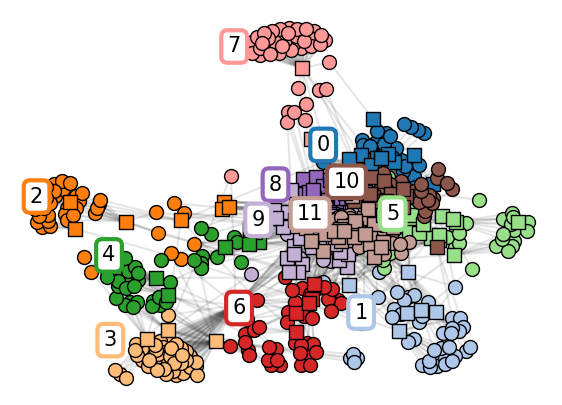

In [167]:
out_path = '../../paper/main_plots/test'
plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path)

# plot rep names


/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/plotting_geneclusters.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


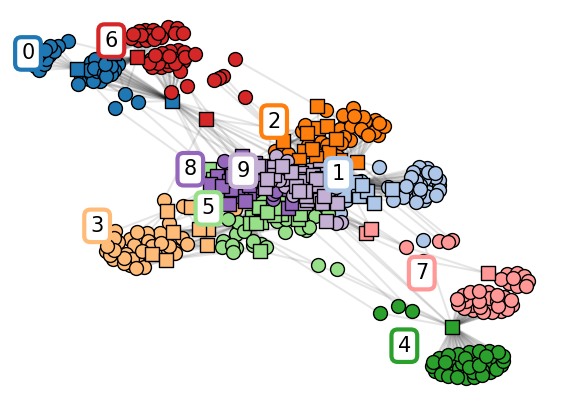

In [12]:
out_path = '../../paper/main_plots/test'
plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path)

# plot rep names


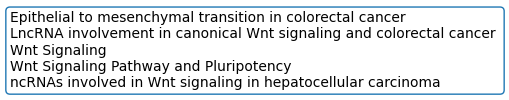

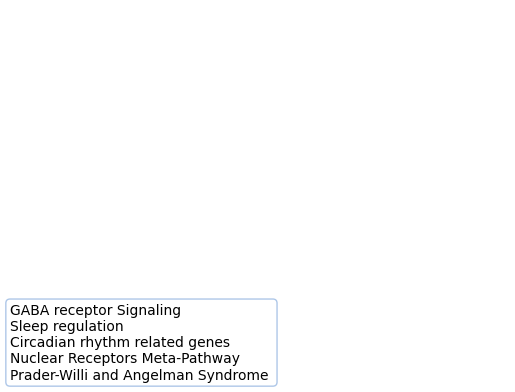

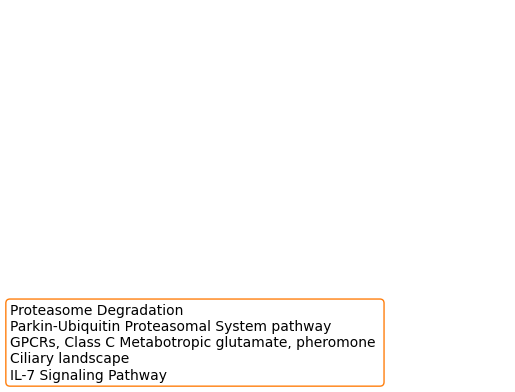

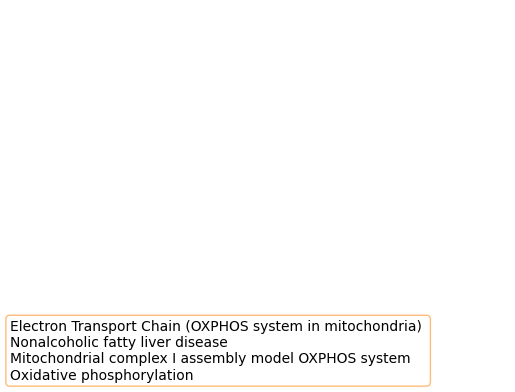

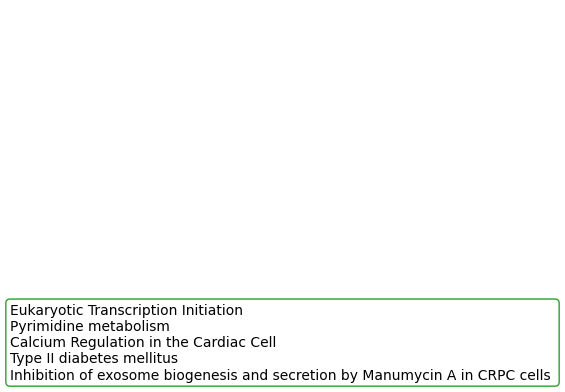

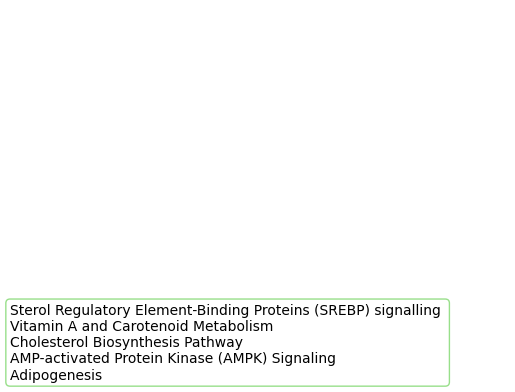

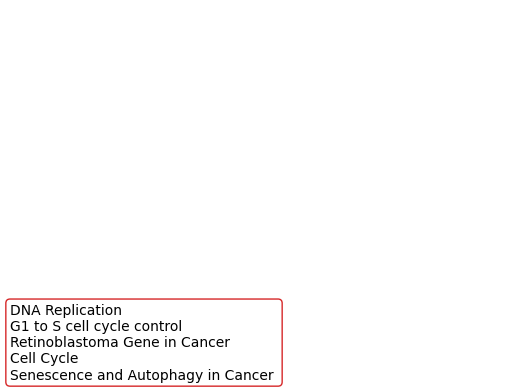

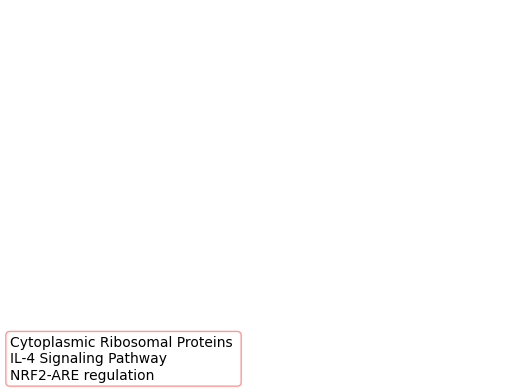

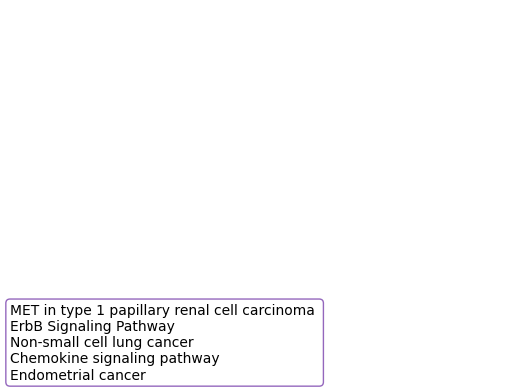

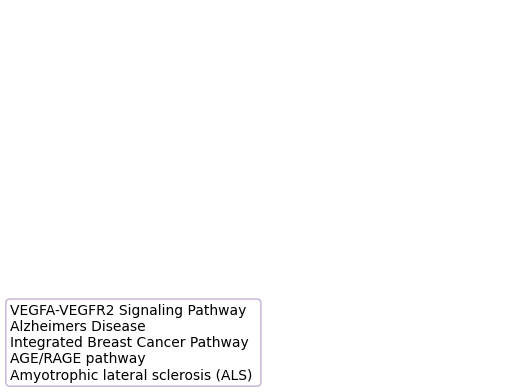

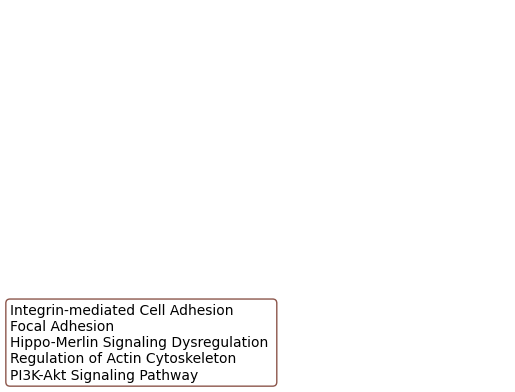

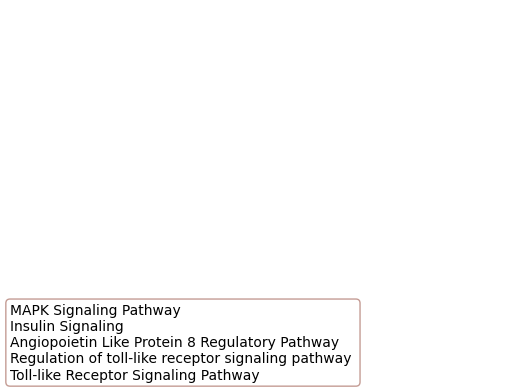

<Figure size 640x480 with 0 Axes>

In [168]:
plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path, 5, cur_labels)

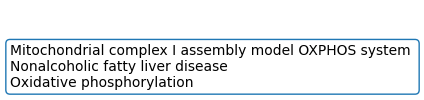

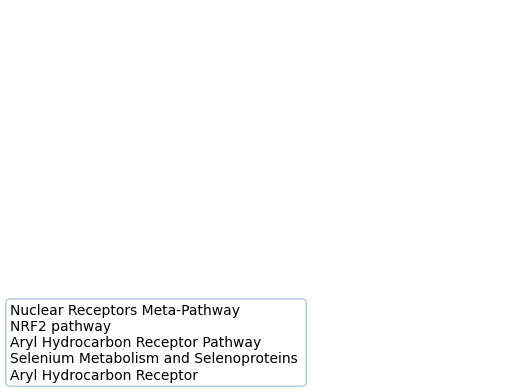

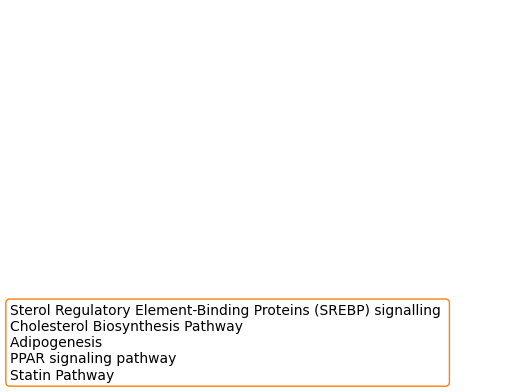

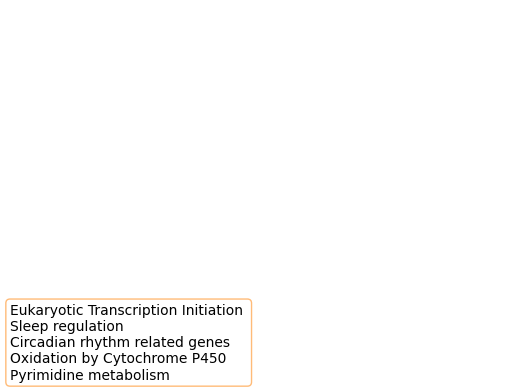

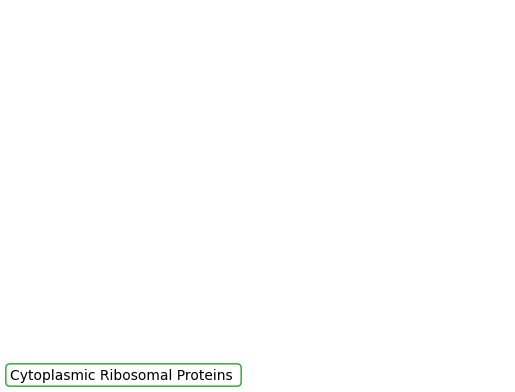

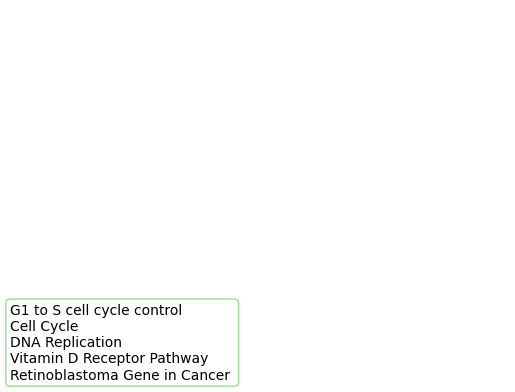

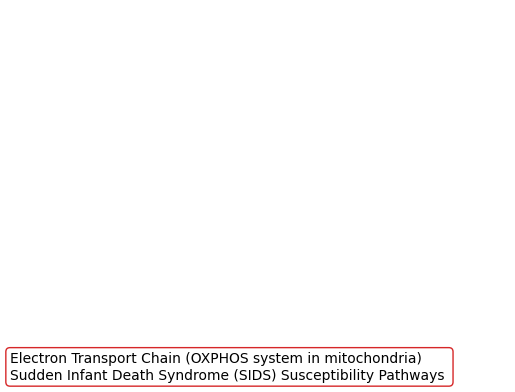

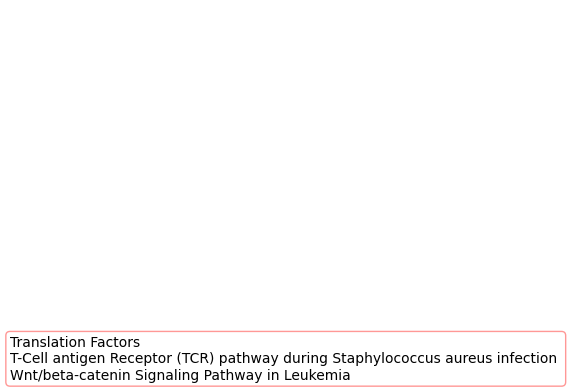

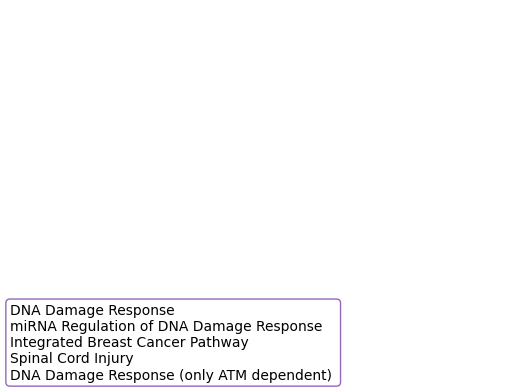

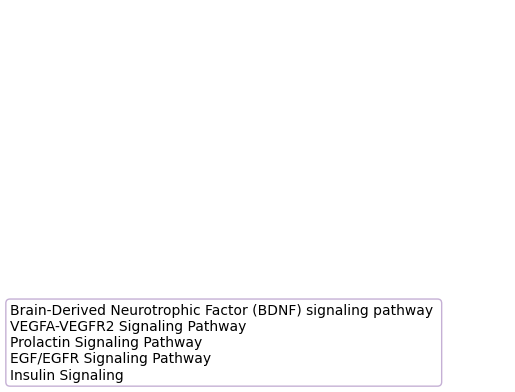

<Figure size 640x480 with 0 Axes>

In [15]:
plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path, 5, cur_labels)

In [57]:
# get clusters for Ex
leading_edge = '../../processed_data/leading_edge_0825Ex.csv'

frame_pm, mat_sub = get_le_clusters(leading_edge, 'Ex', mat, seed, 50)
dictionary = dict(zip(np.unique(frame_pm['cluster']), [2,7,4,1,3,6,5,0]))
frame_pm['cluster'] = [dictionary[x] for x in frame_pm['cluster']]

# plot graph
s=10000
graph, pos, cur_labels_PM, unique_clusters, colors, layout = get_layout(frame_pm, mat_sub, s, 15)#10000

scores = pd.read_csv('../../processed_data/all_scores_0825.csv', index_col=0)

frame_gene = frame[np.invert(frame['is_gene'])]
frame_pm_gene = frame_y[np.invert(frame_y['is_gene'])]

out = np.zeros((len(np.unique(frame_gene['cluster'])), len(np.unique(frame_pm_gene['cluster']))))

for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        x = set(frame_gene[frame_gene['cluster']==i]['description'])
        y = set(frame_pm_gene[frame_pm_gene['cluster']==j]['description'])
        out[i,j] = len(x.intersection(y))/len(x.union(y))



(111, 268)


4it [00:00, 21.93it/s, tot_impr=685, last_impr=0, loss=285] 


In [135]:
d = scores.loc[frame_pm[(frame_pm['is_gene'])]['description']]['Ex']
f = data1.loc[frame[(frame['is_gene'])]['description']]

In [149]:
dd = d[d>0].index
ff = f[f['score']>0].index

In [150]:
len(ff.intersection(dd))/len(ff.union(dd))

0.10326086956521739

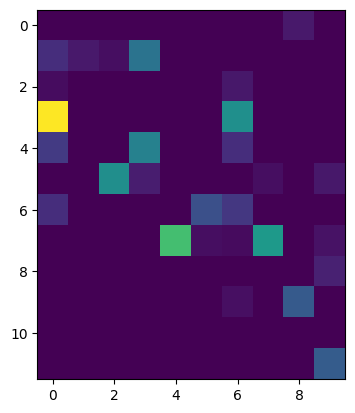

In [181]:
plt.imshow(out, cmap='viridis')#, vmax=1)

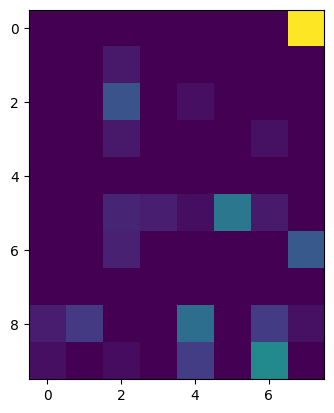

In [114]:
plt.imshow(out, cmap='viridis')#, vmax=1)

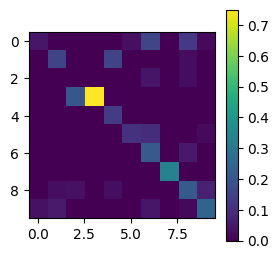

In [185]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
# Suppose 'out' is your similarity matrix.
# Create a cost matrix (negative because we want to maximize overlap)
cost = -out

# Solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cost)

# Reorder the matrix using the found permutation
sorted_out = out[np.ix_(row_ind, col_ind)]

# Display the sorted matrix
plt.imshow(sorted_out, cmap='viridis')#, vmax=1)
plt.colorbar()
plt.show()


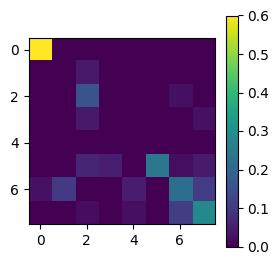

In [115]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

plt.figure(figsize=(3,3))
# Suppose 'out' is your similarity matrix.
# Create a cost matrix (negative because we want to maximize overlap)
cost = -out

# Solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cost)

# Reorder the matrix using the found permutation
sorted_out = out[np.ix_(row_ind, col_ind)]

# Display the sorted matrix
plt.imshow(sorted_out, cmap='viridis')#, vmax=1)
plt.colorbar()
plt.show()


In [83]:
from sklearn.metrics import rand_score, adjusted_rand_score
rand_score(x, y)

ValueError: labels_true must be 1D: shape is ()

Text(0.5, 1.0, 'Jaccard Index')

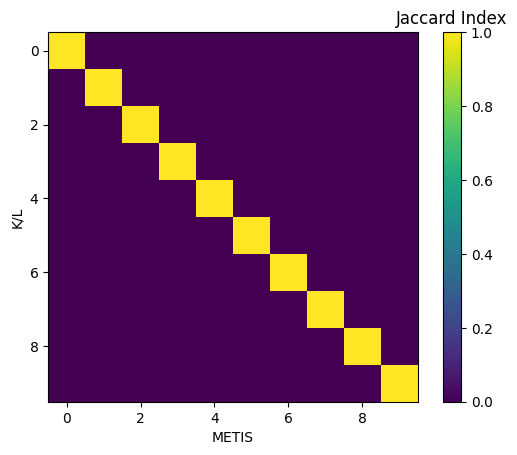

In [49]:
temp = compute_jaccard_all_clust(cur_labels, cur_labels)
T = temp

#o = [7,1,4,6,0,3,2,5]
plt.imshow(temp.T, cmap='viridis', vmax=1, vmin=0)
plt.ylabel('K/L')
plt.xlabel('METIS')
plt.colorbar()

cbar = plt.gcf().axes[-1]
cbar.set_title('Jaccard Index')

#plt.savefig('../../paper/extended_plots/argmins_jaccard.png', bbox_inches='tight')


In [46]:
get_top_genes(frame, scores, 5, 20, 'iN', mat_sub)

,iN,gene,score
genes,,,
CREB3L4,3.818691,CREB3L4,3.818691
PRIM1,2.645254,PRIM1,2.645254
CCNH,2.199494,CCNH,2.199494
UBA52,1.699811,UBA52,1.699811
PRIM2,1.506584,PRIM2,1.506584
MNAT1,1.389999,MNAT1,1.389999
CDKN2C,1.314757,CDKN2C,1.314757
RPA3,1.164946,RPA3,1.164946
CDKN1C,1.054053,CDKN1C,1.054053


#### plot score distributions per cluster

In [186]:
# plot score distributions per cluster
g_names  = np.array(frame['description'][frame['is_gene']])


In [188]:
scores

,iN
genes,
TAF9B,-17.586997
KHDRBS3,17.352830
PRLHR,17.242435
RRAGB,17.155456
ARHGAP36,16.381413
...,...
RWDD4,0.000228
EDF1,0.000189
CFAP52,0.000156


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_35910/1540115427.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp[i], color=colors[i], kde=True,
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_35910/1540115427.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your cod

IndexError: index 10 is out of bounds for axis 0 with size 10

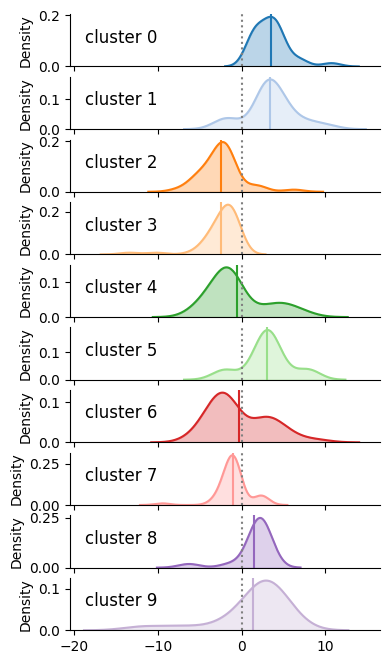

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

In [190]:
scores = pd.DataFrame(data2['score'])
scores.columns = ['iN']
SCORES = np.array(scores.loc[g_names])

temp = [SCORES[frame['cluster'][frame['is_gene']]==i] for i in unique_clusters]
fig, axes = plt.subplots(10, 1, sharex=True, figsize=(4,8))

for i in range(len(temp)):
    plt.figure(figsize = (5,1))

    sns.distplot(temp[i], color=colors[i], kde=True,
        hist=None, label=str(i), ax=axes[i]);
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    axes[i].axvline(np.mean(temp[i]), color=colors[i])#, linestyle='dotted')
    axes[i].axvline(0, color='grey', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)

#fig.savefig(out_path+'_density.pdf')

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_35910/1540115427.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(temp[i], color=colors[i], kde=True,
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_35910/1540115427.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your cod

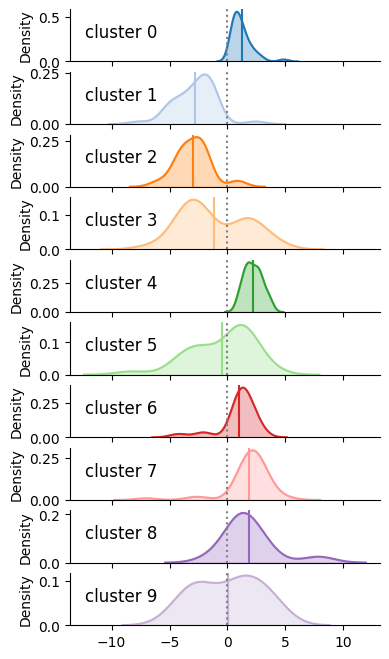

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

<Figure size 500x100 with 0 Axes>

In [29]:


temp = [SCORES[frame['cluster'][frame['is_gene']]==i] for i in unique_clusters]
fig, axes = plt.subplots(10, 1, sharex=True, figsize=(4,8))

for i in range(len(temp)):
    plt.figure(figsize = (5,1))

    sns.distplot(temp[i], color=colors[i], kde=True,
        hist=None, label=str(i), ax=axes[i]);
    l1 = axes[i].lines[0]

    x1 = l1.get_xydata()[:, 0]
    y1 = l1.get_xydata()[:, 1]
    
    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_title('cluster '+str(i), loc='left', y=.3, x=.05)
    axes[i].axvline(np.mean(temp[i]), color=colors[i])#, linestyle='dotted')
    axes[i].axvline(0, color='grey', linestyle='dotted')
    axes[i].fill_between(x1, y1, color=colors[i], alpha=0.3)

#fig.savefig(out_path+'_density.pdf')

#### plot clusters and names

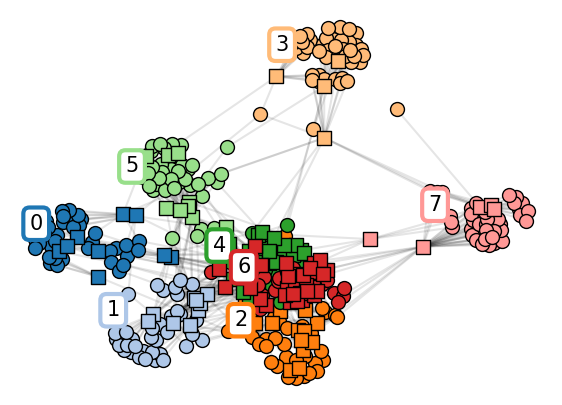

In [10]:
out_path = '../../paper/main_plots/kl_'
plot_graph(layout, pos, graph, cur_labels, unique_clusters, colors, out_path)

# plot rep names


In [ ]:
plot_rep_names(pos, unique_clusters, colors, mat_sub, frame, out_path, 3)

#### plot specific clusters

In [31]:
unique_clusters = np.unique(frame['cluster'])
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(unique_clusters))]

/state/partition1/slurm_tmp/23872437.0.0/ipykernel_811857/599630411.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


/state/partition1/slurm_tmp/23872437.0.0/ipykernel_811857/2080017882.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')
/state/partition1/slurm_tmp/23872437.0.0/ipykernel_811857/2849794604.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23872437.0.0/ipykernel_811857/2849794604.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


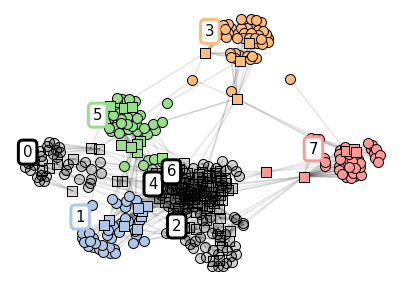

In [35]:
plot_sub_graph_only(list([5,1,3,7]), frame, 'Ex', out_path, layout, graph, pos, cur_labels, scores, mat_sub, (5,5), (2,3), (2,1))

/state/partition1/slurm_tmp/23872437.0.0/ipykernel_811857/2080017882.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')
/state/partition1/slurm_tmp/23872437.0.0/ipykernel_811857/2849794604.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==0].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1)
/state/partition1/slurm_tmp/23872437.0.0/ipykernel_811857/2849794604.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(*pos_curr[types_curr==1].T, color=col, zorder=5, s=S, cmap='tab20', edgecolor="black", linewidth=1, marker='s')


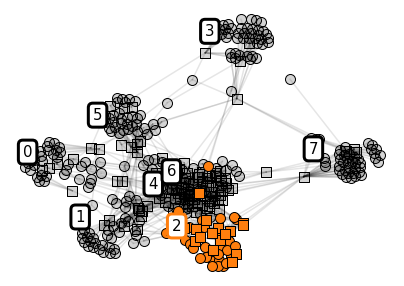

In [36]:
plot_sub_graph_only(list([2]), frame, 'Ex', out_path, layout, graph, pos, cur_labels, scores, mat_sub, (5,5), (2,3), (2,1))

#### plot representative pathways for specific clusters of interest

In [38]:
df = pd.DataFrame(np.vstack([score_rep_paths(frame, mat_sub, scores, x, 'Ex', 5) for x in [1,2,3,5,7]]))
df.columns = np.array(['score', 'path', 's', 'cluster'])

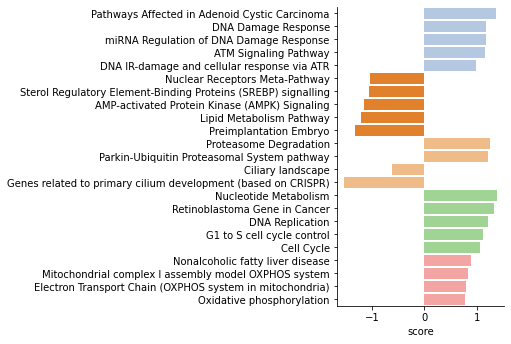

In [56]:
plt.figure(figsize=(3,5.5))

sns.barplot(data=df, x='score', y='path',  palette = [colors[x] for x in df['cluster']])
plt.xlabel('score')
plt.ylabel('')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.savefig('./pdf_figures/rep_paths.pdf')

In [147]:
T = get_top_genes(frame, scores, 4, 30, 'Ex', mat_sub)
T[T['score']> 0]

,Opc,Ast,Ex,Oli,Mic,In,gene,score
WNT2B,-0.430178,0.000000,2.365858,0.000000,2.112835,1.019986,WNT2B,2.365858
TGFB2,0.000000,0.265643,1.871591,0.000000,0.000000,-0.812561,TGFB2,1.871591
FGF5,0.000000,0.000000,1.760421,0.000000,0.000000,0.000000,FGF5,1.760421
MSH6,2.065377,0.000000,1.551225,-0.621585,0.000000,0.100880,MSH6,1.551225
DDB2,-0.009741,-0.176820,1.458102,0.000000,-0.286218,0.000000,DDB2,1.458102
MDM2,-0.000783,0.241611,1.245411,0.115424,0.169147,0.700235,MDM2,1.245411
AKT3,-0.477143,1.435827,1.147859,1.580894,1.078774,0.532310,AKT3,1.147859
PTEN,0.444729,-0.055981,1.125339,0.733725,0.108444,1.029618,PTEN,1.125339
SMAD4,0.339757,-0.100249,0.989757,0.031346,0.526675,0.031316,SMAD4,0.989757
LTBP1,-0.189354,0.770521,0.932233,0.087271,0.000000,0.140247,LTBP1,0.932233


In [118]:
# save clusters to supp 
frame.to_csv('./supplementary_tables/data_s8.csv')